In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset,TensorDataset
from autoencoder2 import Autoencoder2, reduce_dimensions2
import torchvision
from model2 import classification_model
import copy
import partition
from pca import PCADigitReducer
from training import train,test, train_fashion,test_fashion
from federated_learning import distribute_global_model, federated_averaging
from model4 import MultilayerPerceptron
import cluster2
from sklearn.metrics import precision_score, recall_score, f1_score
import time

# Data Preprocessing

In [2]:
n_epochs = 10
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01 # ev. 0.001
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [3]:
# training and testing data as dataloaders

train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.0,), (1,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.0,), (1,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [4]:
train_loader_pca = copy.copy(train_loader)
test_loader_pca = copy.copy(test_loader)

train_loader_auto = copy.copy(train_loader)
test_loader_auto = copy.copy(test_loader)

In [5]:
class CustomTensorDataset(TensorDataset):
    def __init__(self, *tensors):
        super().__init__(*tensors)
        self.data = tensors[0]
        self.targets = tensors[1] 

# Autoencoder

In [6]:
autoencoder2 = Autoencoder2()
auto2_criterion = nn.BCELoss()  
auto2_optimizer = optim.Adam(autoencoder2.parameters(), lr=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
num_epochs = 5 # optimal nach vielen testen
for epoch in range(num_epochs):
    autoencoder2.train()
    train_loss = 0

    for images, _ in train_loader_auto:
        images = images.to(device)

        auto2_optimizer.zero_grad()
        outputs = autoencoder2(images)
        loss = auto2_criterion(outputs, images) 
        
        loss.backward()
        auto2_optimizer.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader_auto)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}")

Epoch [1/5], Loss: 0.1125
Epoch [2/5], Loss: 0.0847
Epoch [3/5], Loss: 0.0805
Epoch [4/5], Loss: 0.0782
Epoch [5/5], Loss: 0.0768


# Experiment

In [8]:
alpha = 0.1
num_clients = 10
num_clusters = [2, 4, 6, 8, 10]
results = {"classic": {}, "pca": {}, "autoencoder": {}}
clusteredResults = {"classic": {}, "pca": {}, "autoencoder": {}}

# Classic

In [9]:
# classic
trainingset = train_loader.dataset
trial_model = classification_model()
global_model_classic = classification_model()
rounds_classic = 4

In [10]:
# Classic
partitioned_data_classic = partition.balanced_dirichlet_partition(
    trainingset, partitions_number=num_clients, alpha=alpha
)

classic_client_loaders = [
    DataLoader(Subset(trainingset, indices), batch_size=batch_size_train, shuffle=True)
    for indices in partitioned_data_classic.values()
]


local_models_classic = [copy.deepcopy(global_model_classic) for _ in range(num_clients)]



for round_idx in range(rounds_classic):
    print(f"Round {round_idx + 1}/{rounds_classic}")
    t1 = time.time()

    local_weights_classic = []
    for client_idx, client_model in enumerate(local_models_classic):
        print(f"Training client {client_idx + 1}")

        optimizer = optim.SGD(client_model.parameters(), lr=learning_rate, momentum=momentum)

        train_losses = []
        train_counter = []

        for epoch in range(1, n_epochs + 1):
            train(epoch, client_model, classic_client_loaders[client_idx], optimizer, log_interval, train_losses, train_counter)

        client_weights = [param.data.numpy() for param in client_model.parameters()]
        local_weights_classic.append(client_weights)

    global_weights_classic = federated_averaging(local_weights_classic)

    distribute_global_model(global_weights_classic, local_models_classic, single=False)
    distribute_global_model(global_weights_classic, global_model_classic, single=True)

    test_losses = []
    test(global_model_classic, test_loader, test_losses)
    t2= time.time()

    
    test_accuracies_classic = []
    correct = 0
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for data, target in test_loader:
            output = global_model_classic(data)
            pred = output.data.max(1, keepdim=True)[1]
            all_preds.extend(pred.cpu().numpy().flatten())
            all_targets.extend(target.cpu().numpy().flatten())
            correct += pred.eq(target.data.view_as(pred)).sum().item()

    accuracy = 100. * correct / len(test_loader.dataset)
    test_accuracies_classic.append(accuracy)
    precision = precision_score(all_targets, all_preds, average='macro')
    recall = recall_score(all_targets, all_preds, average='macro')
    f1 = f1_score(all_targets, all_preds, average='macro')

    
    results["classic"]["NoCluster"] = {"losses": [], "accuracy": [],"precision": [], "recall": [], "f1": [], "trainingTime": []}

    results["classic"]["NoCluster"]["losses"].extend(test_losses)
    results["classic"]["NoCluster"]["accuracy"].extend(test_accuracies_classic)
    results["classic"]["NoCluster"]["precision"].append(precision)
    results["classic"]["NoCluster"]["recall"].append(recall)
    results["classic"]["NoCluster"]["f1"].append(f1)
    results["classic"]["NoCluster"]["trainingTime"].append(t2-t1)

    ######################

for num_cluster in num_clusters:
    import cluster2

    targets = trainingset.targets
    num_classes = len(set(targets)) 
    clients = [cluster2.FederatedClient(cid, indices, targets, num_classes) for cid, indices in partitioned_data_classic.items()]
    client_distributions = [client.compute_label_distribution() for client in clients]
    server = cluster2.FederatedClusterServer(num_cluster)
    aggregated_data = server.aggregate_client_data(client_distributions)
    clustered_data = server.perform_greedy_clustering(aggregated_data, partitioned_data_classic)
    
    partitioned_data_classic_clustered = clustered_data

    """
    import cluster

    cluster = cluster.Cluster(num_clusters=num_cluster)

    targets = trainingset.targets
    num_classes = len(set(targets))
    clustered_data = cluster.apply_clustering(partitioned_data_classic, targets, num_classes)

    partitioned_data_classic_clustered = clustered_data
    """

    classic_client_loaders_clustered = [
        DataLoader(Subset(trainingset, indices), batch_size=batch_size_train, shuffle=True)
        for indices in partitioned_data_classic_clustered.values()
    ]

    for round_idx in range(rounds_classic):
        print(f"Round {round_idx + 1}/{rounds_classic}")
        t1 = time.time()

        local_weights_classic = []
        for client_idx, client_model in enumerate(local_models_classic[0: num_cluster]):
            print(f"Training client {client_idx + 1}")

            optimizer = optim.SGD(client_model.parameters(), lr=learning_rate, momentum=momentum)

            train_losses = []
            train_counter = []

            for epoch in range(1, n_epochs + 1):
                train(epoch, client_model, classic_client_loaders_clustered[client_idx], optimizer, log_interval, train_losses, train_counter)

            client_weights = [param.data.numpy() for param in client_model.parameters()]
            local_weights_classic.append(client_weights)

        global_weights_classic = federated_averaging(local_weights_classic)

        distribute_global_model(global_weights_classic, local_models_classic, single=False)
        distribute_global_model(global_weights_classic, global_model_classic, single=True)

        test_losses = []
        test(global_model_classic, test_loader, test_losses)
        t2= time.time()

        test_accuracies_classic = []
        correct = 0
        all_preds = []
        all_targets = []
        with torch.no_grad():
            for data, target in test_loader:
                output = global_model_classic(data)
                pred = output.data.max(1, keepdim=True)[1]
                all_preds.extend(pred.cpu().numpy().flatten())
                all_targets.extend(target.cpu().numpy().flatten())
                correct += pred.eq(target.data.view_as(pred)).sum().item()

        accuracy = 100. * correct / len(test_loader.dataset)
        test_accuracies_classic.append(accuracy)
        precision = precision_score(all_targets, all_preds, average='macro')
        recall = recall_score(all_targets, all_preds, average='macro')
        f1 = f1_score(all_targets, all_preds, average='macro')

        # Save results for clustered classic
        if num_cluster not in clusteredResults["classic"]:
            clusteredResults["classic"][num_cluster] = {"losses": [], "accuracy": [],"precision": [], "recall": [], "f1": [], "trainingTime": []}

        clusteredResults["classic"][num_cluster]["losses"].extend(test_losses)
        clusteredResults["classic"][num_cluster]["accuracy"].extend(test_accuracies_classic)
        clusteredResults["classic"][num_cluster]["precision"].append(precision)
        clusteredResults["classic"][num_cluster]["recall"].append(recall)
        clusteredResults["classic"][num_cluster]["f1"].append(f1)
        clusteredResults["classic"][num_cluster]["trainingTime"].append(t2-t1)

Round 1/4
Training client 1
Train Epoch: 1 [0/11393 (0%)]	Loss: 2.321368


c:\Users\nazek\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [640/11393 (6%)]	Loss: 2.254162
Train Epoch: 1 [1280/11393 (11%)]	Loss: 2.225052
Train Epoch: 1 [1920/11393 (17%)]	Loss: 2.152625
Train Epoch: 1 [2560/11393 (22%)]	Loss: 2.100670
Train Epoch: 1 [3200/11393 (28%)]	Loss: 2.057718
Train Epoch: 1 [3840/11393 (34%)]	Loss: 1.922730
Train Epoch: 1 [4480/11393 (39%)]	Loss: 1.976943
Train Epoch: 1 [5120/11393 (45%)]	Loss: 1.844926
Train Epoch: 1 [5760/11393 (50%)]	Loss: 1.979931
Train Epoch: 1 [6400/11393 (56%)]	Loss: 1.718920
Train Epoch: 1 [7040/11393 (61%)]	Loss: 1.916713
Train Epoch: 1 [7680/11393 (67%)]	Loss: 1.587780
Train Epoch: 1 [8320/11393 (73%)]	Loss: 1.436871
Train Epoch: 1 [8960/11393 (78%)]	Loss: 1.584264
Train Epoch: 1 [9600/11393 (84%)]	Loss: 1.571929
Train Epoch: 1 [10240/11393 (89%)]	Loss: 1.408770
Train Epoch: 1 [10880/11393 (95%)]	Loss: 1.432968
Train Epoch: 2 [0/11393 (0%)]	Loss: 1.400637
Train Epoch: 2 [640/11393 (6%)]	Loss: 1.148945
Train Epoch: 2 [1280/11393 (11%)]	Loss: 0.983217
Train Epoch: 2 [1920/11393

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.6448, Accuracy: 5089/10000 (51%)



c:\Users\nazek\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\nazek\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Round 2/4
Training client 1
Train Epoch: 1 [0/11393 (0%)]	Loss: 1.855741
Train Epoch: 1 [640/11393 (6%)]	Loss: 1.245102
Train Epoch: 1 [1280/11393 (11%)]	Loss: 0.931898
Train Epoch: 1 [1920/11393 (17%)]	Loss: 0.705256
Train Epoch: 1 [2560/11393 (22%)]	Loss: 0.746199
Train Epoch: 1 [3200/11393 (28%)]	Loss: 0.820231
Train Epoch: 1 [3840/11393 (34%)]	Loss: 0.564205
Train Epoch: 1 [4480/11393 (39%)]	Loss: 0.555267
Train Epoch: 1 [5120/11393 (45%)]	Loss: 0.590234
Train Epoch: 1 [5760/11393 (50%)]	Loss: 0.348299
Train Epoch: 1 [6400/11393 (56%)]	Loss: 0.473845
Train Epoch: 1 [7040/11393 (61%)]	Loss: 0.404349
Train Epoch: 1 [7680/11393 (67%)]	Loss: 0.386397
Train Epoch: 1 [8320/11393 (73%)]	Loss: 0.321653
Train Epoch: 1 [8960/11393 (78%)]	Loss: 0.438132
Train Epoch: 1 [9600/11393 (84%)]	Loss: 0.523321
Train Epoch: 1 [10240/11393 (89%)]	Loss: 0.483891
Train Epoch: 1 [10880/11393 (95%)]	Loss: 0.789871
Train Epoch: 2 [0/11393 (0%)]	Loss: 0.537975
Train Epoch: 2 [640/11393 (6%)]	Loss: 0.359440
Tr

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.5684, Accuracy: 8442/10000 (84%)

Round 3/4
Training client 1
Train Epoch: 1 [0/11393 (0%)]	Loss: 0.883138


c:\Users\nazek\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [640/11393 (6%)]	Loss: 0.774885
Train Epoch: 1 [1280/11393 (11%)]	Loss: 0.366518
Train Epoch: 1 [1920/11393 (17%)]	Loss: 0.382864
Train Epoch: 1 [2560/11393 (22%)]	Loss: 0.362376
Train Epoch: 1 [3200/11393 (28%)]	Loss: 0.287010
Train Epoch: 1 [3840/11393 (34%)]	Loss: 0.435753
Train Epoch: 1 [4480/11393 (39%)]	Loss: 0.631718
Train Epoch: 1 [5120/11393 (45%)]	Loss: 0.482178
Train Epoch: 1 [5760/11393 (50%)]	Loss: 0.210459
Train Epoch: 1 [6400/11393 (56%)]	Loss: 0.307730
Train Epoch: 1 [7040/11393 (61%)]	Loss: 0.508103
Train Epoch: 1 [7680/11393 (67%)]	Loss: 0.412525
Train Epoch: 1 [8320/11393 (73%)]	Loss: 0.476915
Train Epoch: 1 [8960/11393 (78%)]	Loss: 0.274458
Train Epoch: 1 [9600/11393 (84%)]	Loss: 0.485390
Train Epoch: 1 [10240/11393 (89%)]	Loss: 0.375592
Train Epoch: 1 [10880/11393 (95%)]	Loss: 0.218317
Train Epoch: 2 [0/11393 (0%)]	Loss: 0.155292
Train Epoch: 2 [640/11393 (6%)]	Loss: 0.426319
Train Epoch: 2 [1280/11393 (11%)]	Loss: 0.360527
Train Epoch: 2 [1920/11393

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.3255, Accuracy: 9097/10000 (91%)

Round 4/4
Training client 1
Train Epoch: 1 [0/11393 (0%)]	Loss: 0.631453


c:\Users\nazek\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [640/11393 (6%)]	Loss: 0.478668
Train Epoch: 1 [1280/11393 (11%)]	Loss: 0.259439
Train Epoch: 1 [1920/11393 (17%)]	Loss: 0.314512
Train Epoch: 1 [2560/11393 (22%)]	Loss: 0.355186
Train Epoch: 1 [3200/11393 (28%)]	Loss: 0.307330
Train Epoch: 1 [3840/11393 (34%)]	Loss: 0.239076
Train Epoch: 1 [4480/11393 (39%)]	Loss: 0.404418
Train Epoch: 1 [5120/11393 (45%)]	Loss: 0.212018
Train Epoch: 1 [5760/11393 (50%)]	Loss: 0.320273
Train Epoch: 1 [6400/11393 (56%)]	Loss: 0.278264
Train Epoch: 1 [7040/11393 (61%)]	Loss: 0.150392
Train Epoch: 1 [7680/11393 (67%)]	Loss: 0.265122
Train Epoch: 1 [8320/11393 (73%)]	Loss: 0.372814
Train Epoch: 1 [8960/11393 (78%)]	Loss: 0.145400
Train Epoch: 1 [9600/11393 (84%)]	Loss: 0.389899
Train Epoch: 1 [10240/11393 (89%)]	Loss: 0.379063
Train Epoch: 1 [10880/11393 (95%)]	Loss: 0.314205
Train Epoch: 2 [0/11393 (0%)]	Loss: 0.722804
Train Epoch: 2 [640/11393 (6%)]	Loss: 0.368491
Train Epoch: 2 [1280/11393 (11%)]	Loss: 0.460874
Train Epoch: 2 [1920/11393

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.2450, Accuracy: 9290/10000 (93%)

Round 1/4
Training client 1
Train Epoch: 1 [0/37519 (0%)]	Loss: 0.439506


c:\Users\nazek\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [640/37519 (2%)]	Loss: 0.358101
Train Epoch: 1 [1280/37519 (3%)]	Loss: 0.491016
Train Epoch: 1 [1920/37519 (5%)]	Loss: 0.408512
Train Epoch: 1 [2560/37519 (7%)]	Loss: 0.280301
Train Epoch: 1 [3200/37519 (9%)]	Loss: 0.265765
Train Epoch: 1 [3840/37519 (10%)]	Loss: 0.381487
Train Epoch: 1 [4480/37519 (12%)]	Loss: 0.237898
Train Epoch: 1 [5120/37519 (14%)]	Loss: 0.420676
Train Epoch: 1 [5760/37519 (15%)]	Loss: 0.478874
Train Epoch: 1 [6400/37519 (17%)]	Loss: 0.289958
Train Epoch: 1 [7040/37519 (19%)]	Loss: 0.267838
Train Epoch: 1 [7680/37519 (20%)]	Loss: 0.363784
Train Epoch: 1 [8320/37519 (22%)]	Loss: 0.174742
Train Epoch: 1 [8960/37519 (24%)]	Loss: 0.269068
Train Epoch: 1 [9600/37519 (26%)]	Loss: 0.267111
Train Epoch: 1 [10240/37519 (27%)]	Loss: 0.422995
Train Epoch: 1 [10880/37519 (29%)]	Loss: 0.320953
Train Epoch: 1 [11520/37519 (31%)]	Loss: 0.459425
Train Epoch: 1 [12160/37519 (32%)]	Loss: 0.338334
Train Epoch: 1 [12800/37519 (34%)]	Loss: 0.506632
Train Epoch: 1 [13440

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.1205, Accuracy: 9627/10000 (96%)

Round 2/4
Training client 1
Train Epoch: 1 [0/37519 (0%)]	Loss: 0.321539


c:\Users\nazek\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [640/37519 (2%)]	Loss: 0.343194
Train Epoch: 1 [1280/37519 (3%)]	Loss: 0.247093
Train Epoch: 1 [1920/37519 (5%)]	Loss: 0.415553
Train Epoch: 1 [2560/37519 (7%)]	Loss: 0.163176
Train Epoch: 1 [3200/37519 (9%)]	Loss: 0.291163
Train Epoch: 1 [3840/37519 (10%)]	Loss: 0.145428
Train Epoch: 1 [4480/37519 (12%)]	Loss: 0.311284
Train Epoch: 1 [5120/37519 (14%)]	Loss: 0.297041
Train Epoch: 1 [5760/37519 (15%)]	Loss: 0.176913
Train Epoch: 1 [6400/37519 (17%)]	Loss: 0.243336
Train Epoch: 1 [7040/37519 (19%)]	Loss: 0.188966
Train Epoch: 1 [7680/37519 (20%)]	Loss: 0.188353
Train Epoch: 1 [8320/37519 (22%)]	Loss: 0.060175
Train Epoch: 1 [8960/37519 (24%)]	Loss: 0.151955
Train Epoch: 1 [9600/37519 (26%)]	Loss: 0.166274
Train Epoch: 1 [10240/37519 (27%)]	Loss: 0.430083
Train Epoch: 1 [10880/37519 (29%)]	Loss: 0.265744
Train Epoch: 1 [11520/37519 (31%)]	Loss: 0.099401
Train Epoch: 1 [12160/37519 (32%)]	Loss: 0.188829
Train Epoch: 1 [12800/37519 (34%)]	Loss: 0.116957
Train Epoch: 1 [13440

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0875, Accuracy: 9719/10000 (97%)

Round 3/4
Training client 1
Train Epoch: 1 [0/37519 (0%)]	Loss: 0.256361


c:\Users\nazek\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [640/37519 (2%)]	Loss: 0.257438
Train Epoch: 1 [1280/37519 (3%)]	Loss: 0.117740
Train Epoch: 1 [1920/37519 (5%)]	Loss: 0.172869
Train Epoch: 1 [2560/37519 (7%)]	Loss: 0.187357
Train Epoch: 1 [3200/37519 (9%)]	Loss: 0.192296
Train Epoch: 1 [3840/37519 (10%)]	Loss: 0.219180
Train Epoch: 1 [4480/37519 (12%)]	Loss: 0.156605
Train Epoch: 1 [5120/37519 (14%)]	Loss: 0.236134
Train Epoch: 1 [5760/37519 (15%)]	Loss: 0.287349
Train Epoch: 1 [6400/37519 (17%)]	Loss: 0.372908
Train Epoch: 1 [7040/37519 (19%)]	Loss: 0.217291
Train Epoch: 1 [7680/37519 (20%)]	Loss: 0.111678
Train Epoch: 1 [8320/37519 (22%)]	Loss: 0.112427
Train Epoch: 1 [8960/37519 (24%)]	Loss: 0.092645
Train Epoch: 1 [9600/37519 (26%)]	Loss: 0.088817
Train Epoch: 1 [10240/37519 (27%)]	Loss: 0.201081
Train Epoch: 1 [10880/37519 (29%)]	Loss: 0.127409
Train Epoch: 1 [11520/37519 (31%)]	Loss: 0.157716
Train Epoch: 1 [12160/37519 (32%)]	Loss: 0.165577
Train Epoch: 1 [12800/37519 (34%)]	Loss: 0.164363
Train Epoch: 1 [13440

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0725, Accuracy: 9767/10000 (98%)

Round 4/4
Training client 1
Train Epoch: 1 [0/37519 (0%)]	Loss: 0.061204


c:\Users\nazek\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [640/37519 (2%)]	Loss: 0.375767
Train Epoch: 1 [1280/37519 (3%)]	Loss: 0.245640
Train Epoch: 1 [1920/37519 (5%)]	Loss: 0.088440
Train Epoch: 1 [2560/37519 (7%)]	Loss: 0.229893
Train Epoch: 1 [3200/37519 (9%)]	Loss: 0.354696
Train Epoch: 1 [3840/37519 (10%)]	Loss: 0.198041
Train Epoch: 1 [4480/37519 (12%)]	Loss: 0.178551
Train Epoch: 1 [5120/37519 (14%)]	Loss: 0.109354
Train Epoch: 1 [5760/37519 (15%)]	Loss: 0.136856
Train Epoch: 1 [6400/37519 (17%)]	Loss: 0.095294
Train Epoch: 1 [7040/37519 (19%)]	Loss: 0.075522
Train Epoch: 1 [7680/37519 (20%)]	Loss: 0.160552
Train Epoch: 1 [8320/37519 (22%)]	Loss: 0.133778
Train Epoch: 1 [8960/37519 (24%)]	Loss: 0.265775
Train Epoch: 1 [9600/37519 (26%)]	Loss: 0.163601
Train Epoch: 1 [10240/37519 (27%)]	Loss: 0.079651
Train Epoch: 1 [10880/37519 (29%)]	Loss: 0.088700
Train Epoch: 1 [11520/37519 (31%)]	Loss: 0.108204
Train Epoch: 1 [12160/37519 (32%)]	Loss: 0.502334
Train Epoch: 1 [12800/37519 (34%)]	Loss: 0.082744
Train Epoch: 1 [13440

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0608, Accuracy: 9814/10000 (98%)

Round 1/4
Training client 1
Train Epoch: 1 [0/18662 (0%)]	Loss: 0.243080


c:\Users\nazek\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [640/18662 (3%)]	Loss: 0.111780
Train Epoch: 1 [1280/18662 (7%)]	Loss: 0.064580
Train Epoch: 1 [1920/18662 (10%)]	Loss: 0.068523
Train Epoch: 1 [2560/18662 (14%)]	Loss: 0.059840
Train Epoch: 1 [3200/18662 (17%)]	Loss: 0.127855
Train Epoch: 1 [3840/18662 (21%)]	Loss: 0.111412
Train Epoch: 1 [4480/18662 (24%)]	Loss: 0.185078
Train Epoch: 1 [5120/18662 (27%)]	Loss: 0.189730
Train Epoch: 1 [5760/18662 (31%)]	Loss: 0.108250
Train Epoch: 1 [6400/18662 (34%)]	Loss: 0.262335
Train Epoch: 1 [7040/18662 (38%)]	Loss: 0.038459
Train Epoch: 1 [7680/18662 (41%)]	Loss: 0.065056
Train Epoch: 1 [8320/18662 (45%)]	Loss: 0.143644
Train Epoch: 1 [8960/18662 (48%)]	Loss: 0.113351
Train Epoch: 1 [9600/18662 (51%)]	Loss: 0.100093
Train Epoch: 1 [10240/18662 (55%)]	Loss: 0.036720
Train Epoch: 1 [10880/18662 (58%)]	Loss: 0.087962
Train Epoch: 1 [11520/18662 (62%)]	Loss: 0.085151
Train Epoch: 1 [12160/18662 (65%)]	Loss: 0.110197
Train Epoch: 1 [12800/18662 (68%)]	Loss: 0.026393
Train Epoch: 1 [13

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0600, Accuracy: 9810/10000 (98%)

Round 2/4
Training client 1
Train Epoch: 1 [0/18662 (0%)]	Loss: 0.261872


c:\Users\nazek\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [640/18662 (3%)]	Loss: 0.137298
Train Epoch: 1 [1280/18662 (7%)]	Loss: 0.040660
Train Epoch: 1 [1920/18662 (10%)]	Loss: 0.144707
Train Epoch: 1 [2560/18662 (14%)]	Loss: 0.227213
Train Epoch: 1 [3200/18662 (17%)]	Loss: 0.083728
Train Epoch: 1 [3840/18662 (21%)]	Loss: 0.182354
Train Epoch: 1 [4480/18662 (24%)]	Loss: 0.062007
Train Epoch: 1 [5120/18662 (27%)]	Loss: 0.075902
Train Epoch: 1 [5760/18662 (31%)]	Loss: 0.095238
Train Epoch: 1 [6400/18662 (34%)]	Loss: 0.064334
Train Epoch: 1 [7040/18662 (38%)]	Loss: 0.015453
Train Epoch: 1 [7680/18662 (41%)]	Loss: 0.071626
Train Epoch: 1 [8320/18662 (45%)]	Loss: 0.099451
Train Epoch: 1 [8960/18662 (48%)]	Loss: 0.057233
Train Epoch: 1 [9600/18662 (51%)]	Loss: 0.059934
Train Epoch: 1 [10240/18662 (55%)]	Loss: 0.074383
Train Epoch: 1 [10880/18662 (58%)]	Loss: 0.072503
Train Epoch: 1 [11520/18662 (62%)]	Loss: 0.044070
Train Epoch: 1 [12160/18662 (65%)]	Loss: 0.033844
Train Epoch: 1 [12800/18662 (68%)]	Loss: 0.075945
Train Epoch: 1 [13

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0584, Accuracy: 9812/10000 (98%)

Round 3/4
Training client 1
Train Epoch: 1 [0/18662 (0%)]	Loss: 0.149737


c:\Users\nazek\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [640/18662 (3%)]	Loss: 0.139703
Train Epoch: 1 [1280/18662 (7%)]	Loss: 0.042328
Train Epoch: 1 [1920/18662 (10%)]	Loss: 0.031729
Train Epoch: 1 [2560/18662 (14%)]	Loss: 0.023443
Train Epoch: 1 [3200/18662 (17%)]	Loss: 0.085479
Train Epoch: 1 [3840/18662 (21%)]	Loss: 0.062794
Train Epoch: 1 [4480/18662 (24%)]	Loss: 0.126265
Train Epoch: 1 [5120/18662 (27%)]	Loss: 0.088497
Train Epoch: 1 [5760/18662 (31%)]	Loss: 0.079536
Train Epoch: 1 [6400/18662 (34%)]	Loss: 0.177763
Train Epoch: 1 [7040/18662 (38%)]	Loss: 0.145364
Train Epoch: 1 [7680/18662 (41%)]	Loss: 0.160149
Train Epoch: 1 [8320/18662 (45%)]	Loss: 0.144796
Train Epoch: 1 [8960/18662 (48%)]	Loss: 0.255469
Train Epoch: 1 [9600/18662 (51%)]	Loss: 0.094519
Train Epoch: 1 [10240/18662 (55%)]	Loss: 0.082487
Train Epoch: 1 [10880/18662 (58%)]	Loss: 0.307029
Train Epoch: 1 [11520/18662 (62%)]	Loss: 0.026659
Train Epoch: 1 [12160/18662 (65%)]	Loss: 0.084279
Train Epoch: 1 [12800/18662 (68%)]	Loss: 0.146961
Train Epoch: 1 [13

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0567, Accuracy: 9819/10000 (98%)

Round 4/4
Training client 1
Train Epoch: 1 [0/18662 (0%)]	Loss: 0.209593


c:\Users\nazek\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [640/18662 (3%)]	Loss: 0.038160
Train Epoch: 1 [1280/18662 (7%)]	Loss: 0.040569
Train Epoch: 1 [1920/18662 (10%)]	Loss: 0.028167
Train Epoch: 1 [2560/18662 (14%)]	Loss: 0.094809
Train Epoch: 1 [3200/18662 (17%)]	Loss: 0.065822
Train Epoch: 1 [3840/18662 (21%)]	Loss: 0.051706
Train Epoch: 1 [4480/18662 (24%)]	Loss: 0.042569
Train Epoch: 1 [5120/18662 (27%)]	Loss: 0.026668
Train Epoch: 1 [5760/18662 (31%)]	Loss: 0.171902
Train Epoch: 1 [6400/18662 (34%)]	Loss: 0.074271
Train Epoch: 1 [7040/18662 (38%)]	Loss: 0.103579
Train Epoch: 1 [7680/18662 (41%)]	Loss: 0.108176
Train Epoch: 1 [8320/18662 (45%)]	Loss: 0.020384
Train Epoch: 1 [8960/18662 (48%)]	Loss: 0.089042
Train Epoch: 1 [9600/18662 (51%)]	Loss: 0.131873
Train Epoch: 1 [10240/18662 (55%)]	Loss: 0.193767
Train Epoch: 1 [10880/18662 (58%)]	Loss: 0.086088
Train Epoch: 1 [11520/18662 (62%)]	Loss: 0.058328
Train Epoch: 1 [12160/18662 (65%)]	Loss: 0.125292
Train Epoch: 1 [12800/18662 (68%)]	Loss: 0.031078
Train Epoch: 1 [13

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0531, Accuracy: 9832/10000 (98%)

Round 1/4
Training client 1
Train Epoch: 1 [0/11393 (0%)]	Loss: 0.141727


c:\Users\nazek\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [640/11393 (6%)]	Loss: 0.128378
Train Epoch: 1 [1280/11393 (11%)]	Loss: 0.093886
Train Epoch: 1 [1920/11393 (17%)]	Loss: 0.061844
Train Epoch: 1 [2560/11393 (22%)]	Loss: 0.089514
Train Epoch: 1 [3200/11393 (28%)]	Loss: 0.082249
Train Epoch: 1 [3840/11393 (34%)]	Loss: 0.106634
Train Epoch: 1 [4480/11393 (39%)]	Loss: 0.089307
Train Epoch: 1 [5120/11393 (45%)]	Loss: 0.125531
Train Epoch: 1 [5760/11393 (50%)]	Loss: 0.261826
Train Epoch: 1 [6400/11393 (56%)]	Loss: 0.090161
Train Epoch: 1 [7040/11393 (61%)]	Loss: 0.039355
Train Epoch: 1 [7680/11393 (67%)]	Loss: 0.075529
Train Epoch: 1 [8320/11393 (73%)]	Loss: 0.214002
Train Epoch: 1 [8960/11393 (78%)]	Loss: 0.084243
Train Epoch: 1 [9600/11393 (84%)]	Loss: 0.269753
Train Epoch: 1 [10240/11393 (89%)]	Loss: 0.046773
Train Epoch: 1 [10880/11393 (95%)]	Loss: 0.160927
Train Epoch: 2 [0/11393 (0%)]	Loss: 0.097680
Train Epoch: 2 [640/11393 (6%)]	Loss: 0.084612
Train Epoch: 2 [1280/11393 (11%)]	Loss: 0.047288
Train Epoch: 2 [1920/11393

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0507, Accuracy: 9829/10000 (98%)

Round 2/4
Training client 1
Train Epoch: 1 [0/11393 (0%)]	Loss: 0.064220


c:\Users\nazek\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [640/11393 (6%)]	Loss: 0.080172
Train Epoch: 1 [1280/11393 (11%)]	Loss: 0.080411
Train Epoch: 1 [1920/11393 (17%)]	Loss: 0.093185
Train Epoch: 1 [2560/11393 (22%)]	Loss: 0.169064
Train Epoch: 1 [3200/11393 (28%)]	Loss: 0.032007
Train Epoch: 1 [3840/11393 (34%)]	Loss: 0.063327
Train Epoch: 1 [4480/11393 (39%)]	Loss: 0.106697
Train Epoch: 1 [5120/11393 (45%)]	Loss: 0.027452
Train Epoch: 1 [5760/11393 (50%)]	Loss: 0.073569
Train Epoch: 1 [6400/11393 (56%)]	Loss: 0.037638
Train Epoch: 1 [7040/11393 (61%)]	Loss: 0.084929
Train Epoch: 1 [7680/11393 (67%)]	Loss: 0.164901
Train Epoch: 1 [8320/11393 (73%)]	Loss: 0.108085
Train Epoch: 1 [8960/11393 (78%)]	Loss: 0.301310
Train Epoch: 1 [9600/11393 (84%)]	Loss: 0.166458
Train Epoch: 1 [10240/11393 (89%)]	Loss: 0.083375
Train Epoch: 1 [10880/11393 (95%)]	Loss: 0.048274
Train Epoch: 2 [0/11393 (0%)]	Loss: 0.118148
Train Epoch: 2 [640/11393 (6%)]	Loss: 0.090944
Train Epoch: 2 [1280/11393 (11%)]	Loss: 0.043337
Train Epoch: 2 [1920/11393

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0497, Accuracy: 9836/10000 (98%)

Round 3/4
Training client 1
Train Epoch: 1 [0/11393 (0%)]	Loss: 0.054686


c:\Users\nazek\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [640/11393 (6%)]	Loss: 0.132831
Train Epoch: 1 [1280/11393 (11%)]	Loss: 0.158615
Train Epoch: 1 [1920/11393 (17%)]	Loss: 0.092034
Train Epoch: 1 [2560/11393 (22%)]	Loss: 0.061135
Train Epoch: 1 [3200/11393 (28%)]	Loss: 0.145744
Train Epoch: 1 [3840/11393 (34%)]	Loss: 0.044193
Train Epoch: 1 [4480/11393 (39%)]	Loss: 0.048062
Train Epoch: 1 [5120/11393 (45%)]	Loss: 0.047128
Train Epoch: 1 [5760/11393 (50%)]	Loss: 0.036056
Train Epoch: 1 [6400/11393 (56%)]	Loss: 0.114334
Train Epoch: 1 [7040/11393 (61%)]	Loss: 0.122531
Train Epoch: 1 [7680/11393 (67%)]	Loss: 0.076034
Train Epoch: 1 [8320/11393 (73%)]	Loss: 0.154468
Train Epoch: 1 [8960/11393 (78%)]	Loss: 0.106877
Train Epoch: 1 [9600/11393 (84%)]	Loss: 0.110798
Train Epoch: 1 [10240/11393 (89%)]	Loss: 0.096385
Train Epoch: 1 [10880/11393 (95%)]	Loss: 0.135421
Train Epoch: 2 [0/11393 (0%)]	Loss: 0.080741
Train Epoch: 2 [640/11393 (6%)]	Loss: 0.184560
Train Epoch: 2 [1280/11393 (11%)]	Loss: 0.022290
Train Epoch: 2 [1920/11393

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0530, Accuracy: 9824/10000 (98%)

Round 4/4
Training client 1
Train Epoch: 1 [0/11393 (0%)]	Loss: 0.093645


c:\Users\nazek\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [640/11393 (6%)]	Loss: 0.104687
Train Epoch: 1 [1280/11393 (11%)]	Loss: 0.122727
Train Epoch: 1 [1920/11393 (17%)]	Loss: 0.046322
Train Epoch: 1 [2560/11393 (22%)]	Loss: 0.055008
Train Epoch: 1 [3200/11393 (28%)]	Loss: 0.137863
Train Epoch: 1 [3840/11393 (34%)]	Loss: 0.078501
Train Epoch: 1 [4480/11393 (39%)]	Loss: 0.044918
Train Epoch: 1 [5120/11393 (45%)]	Loss: 0.109033
Train Epoch: 1 [5760/11393 (50%)]	Loss: 0.165140
Train Epoch: 1 [6400/11393 (56%)]	Loss: 0.063895
Train Epoch: 1 [7040/11393 (61%)]	Loss: 0.050198
Train Epoch: 1 [7680/11393 (67%)]	Loss: 0.099931
Train Epoch: 1 [8320/11393 (73%)]	Loss: 0.023959
Train Epoch: 1 [8960/11393 (78%)]	Loss: 0.128812
Train Epoch: 1 [9600/11393 (84%)]	Loss: 0.009380
Train Epoch: 1 [10240/11393 (89%)]	Loss: 0.036356
Train Epoch: 1 [10880/11393 (95%)]	Loss: 0.051907
Train Epoch: 2 [0/11393 (0%)]	Loss: 0.045979
Train Epoch: 2 [640/11393 (6%)]	Loss: 0.152569
Train Epoch: 2 [1280/11393 (11%)]	Loss: 0.062294
Train Epoch: 2 [1920/11393

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0488, Accuracy: 9835/10000 (98%)

Round 1/4
Training client 1
Train Epoch: 1 [0/11393 (0%)]	Loss: 0.101219


c:\Users\nazek\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [640/11393 (6%)]	Loss: 0.028153
Train Epoch: 1 [1280/11393 (11%)]	Loss: 0.094085
Train Epoch: 1 [1920/11393 (17%)]	Loss: 0.029394
Train Epoch: 1 [2560/11393 (22%)]	Loss: 0.024223
Train Epoch: 1 [3200/11393 (28%)]	Loss: 0.018119
Train Epoch: 1 [3840/11393 (34%)]	Loss: 0.060637
Train Epoch: 1 [4480/11393 (39%)]	Loss: 0.266606
Train Epoch: 1 [5120/11393 (45%)]	Loss: 0.061310
Train Epoch: 1 [5760/11393 (50%)]	Loss: 0.033314
Train Epoch: 1 [6400/11393 (56%)]	Loss: 0.068547
Train Epoch: 1 [7040/11393 (61%)]	Loss: 0.127617
Train Epoch: 1 [7680/11393 (67%)]	Loss: 0.067547
Train Epoch: 1 [8320/11393 (73%)]	Loss: 0.050878
Train Epoch: 1 [8960/11393 (78%)]	Loss: 0.070583
Train Epoch: 1 [9600/11393 (84%)]	Loss: 0.029494
Train Epoch: 1 [10240/11393 (89%)]	Loss: 0.215069
Train Epoch: 1 [10880/11393 (95%)]	Loss: 0.083442
Train Epoch: 2 [0/11393 (0%)]	Loss: 0.083135
Train Epoch: 2 [640/11393 (6%)]	Loss: 0.099604
Train Epoch: 2 [1280/11393 (11%)]	Loss: 0.040353
Train Epoch: 2 [1920/11393

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0437, Accuracy: 9851/10000 (99%)

Round 2/4
Training client 1
Train Epoch: 1 [0/11393 (0%)]	Loss: 0.106371


c:\Users\nazek\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [640/11393 (6%)]	Loss: 0.611295
Train Epoch: 1 [1280/11393 (11%)]	Loss: 0.219449
Train Epoch: 1 [1920/11393 (17%)]	Loss: 0.086892
Train Epoch: 1 [2560/11393 (22%)]	Loss: 0.098397
Train Epoch: 1 [3200/11393 (28%)]	Loss: 0.101174
Train Epoch: 1 [3840/11393 (34%)]	Loss: 0.093532
Train Epoch: 1 [4480/11393 (39%)]	Loss: 0.084382
Train Epoch: 1 [5120/11393 (45%)]	Loss: 0.124365
Train Epoch: 1 [5760/11393 (50%)]	Loss: 0.065343
Train Epoch: 1 [6400/11393 (56%)]	Loss: 0.101068
Train Epoch: 1 [7040/11393 (61%)]	Loss: 0.127019
Train Epoch: 1 [7680/11393 (67%)]	Loss: 0.021051
Train Epoch: 1 [8320/11393 (73%)]	Loss: 0.041483
Train Epoch: 1 [8960/11393 (78%)]	Loss: 0.055789
Train Epoch: 1 [9600/11393 (84%)]	Loss: 0.116171
Train Epoch: 1 [10240/11393 (89%)]	Loss: 0.049026
Train Epoch: 1 [10880/11393 (95%)]	Loss: 0.028517
Train Epoch: 2 [0/11393 (0%)]	Loss: 0.055166
Train Epoch: 2 [640/11393 (6%)]	Loss: 0.096119
Train Epoch: 2 [1280/11393 (11%)]	Loss: 0.072584
Train Epoch: 2 [1920/11393

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0432, Accuracy: 9848/10000 (98%)

Round 3/4
Training client 1
Train Epoch: 1 [0/11393 (0%)]	Loss: 0.065423


c:\Users\nazek\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [640/11393 (6%)]	Loss: 0.058666
Train Epoch: 1 [1280/11393 (11%)]	Loss: 0.074719
Train Epoch: 1 [1920/11393 (17%)]	Loss: 0.097163
Train Epoch: 1 [2560/11393 (22%)]	Loss: 0.151470
Train Epoch: 1 [3200/11393 (28%)]	Loss: 0.102882
Train Epoch: 1 [3840/11393 (34%)]	Loss: 0.039011
Train Epoch: 1 [4480/11393 (39%)]	Loss: 0.055032
Train Epoch: 1 [5120/11393 (45%)]	Loss: 0.021643
Train Epoch: 1 [5760/11393 (50%)]	Loss: 0.129004
Train Epoch: 1 [6400/11393 (56%)]	Loss: 0.069806
Train Epoch: 1 [7040/11393 (61%)]	Loss: 0.036718
Train Epoch: 1 [7680/11393 (67%)]	Loss: 0.042264
Train Epoch: 1 [8320/11393 (73%)]	Loss: 0.030582
Train Epoch: 1 [8960/11393 (78%)]	Loss: 0.064626
Train Epoch: 1 [9600/11393 (84%)]	Loss: 0.116058
Train Epoch: 1 [10240/11393 (89%)]	Loss: 0.083707
Train Epoch: 1 [10880/11393 (95%)]	Loss: 0.073416
Train Epoch: 2 [0/11393 (0%)]	Loss: 0.197532
Train Epoch: 2 [640/11393 (6%)]	Loss: 0.054585
Train Epoch: 2 [1280/11393 (11%)]	Loss: 0.052257
Train Epoch: 2 [1920/11393

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0428, Accuracy: 9855/10000 (99%)

Round 4/4
Training client 1
Train Epoch: 1 [0/11393 (0%)]	Loss: 0.119200


c:\Users\nazek\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [640/11393 (6%)]	Loss: 0.023813
Train Epoch: 1 [1280/11393 (11%)]	Loss: 0.103287
Train Epoch: 1 [1920/11393 (17%)]	Loss: 0.093234
Train Epoch: 1 [2560/11393 (22%)]	Loss: 0.084019
Train Epoch: 1 [3200/11393 (28%)]	Loss: 0.042896
Train Epoch: 1 [3840/11393 (34%)]	Loss: 0.041447
Train Epoch: 1 [4480/11393 (39%)]	Loss: 0.064021
Train Epoch: 1 [5120/11393 (45%)]	Loss: 0.111832
Train Epoch: 1 [5760/11393 (50%)]	Loss: 0.048593
Train Epoch: 1 [6400/11393 (56%)]	Loss: 0.070229
Train Epoch: 1 [7040/11393 (61%)]	Loss: 0.050948
Train Epoch: 1 [7680/11393 (67%)]	Loss: 0.080818
Train Epoch: 1 [8320/11393 (73%)]	Loss: 0.067781
Train Epoch: 1 [8960/11393 (78%)]	Loss: 0.084422
Train Epoch: 1 [9600/11393 (84%)]	Loss: 0.029735
Train Epoch: 1 [10240/11393 (89%)]	Loss: 0.110257
Train Epoch: 1 [10880/11393 (95%)]	Loss: 0.037412
Train Epoch: 2 [0/11393 (0%)]	Loss: 0.037024
Train Epoch: 2 [640/11393 (6%)]	Loss: 0.065199
Train Epoch: 2 [1280/11393 (11%)]	Loss: 0.048941
Train Epoch: 2 [1920/11393

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0425, Accuracy: 9856/10000 (99%)

Round 1/4
Training client 1
Train Epoch: 1 [0/11393 (0%)]	Loss: 0.102164


c:\Users\nazek\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [640/11393 (6%)]	Loss: 0.154266
Train Epoch: 1 [1280/11393 (11%)]	Loss: 0.048811
Train Epoch: 1 [1920/11393 (17%)]	Loss: 0.050801
Train Epoch: 1 [2560/11393 (22%)]	Loss: 0.116319
Train Epoch: 1 [3200/11393 (28%)]	Loss: 0.049751
Train Epoch: 1 [3840/11393 (34%)]	Loss: 0.072199
Train Epoch: 1 [4480/11393 (39%)]	Loss: 0.155834
Train Epoch: 1 [5120/11393 (45%)]	Loss: 0.123118
Train Epoch: 1 [5760/11393 (50%)]	Loss: 0.032407
Train Epoch: 1 [6400/11393 (56%)]	Loss: 0.063195
Train Epoch: 1 [7040/11393 (61%)]	Loss: 0.061443
Train Epoch: 1 [7680/11393 (67%)]	Loss: 0.079497
Train Epoch: 1 [8320/11393 (73%)]	Loss: 0.090529
Train Epoch: 1 [8960/11393 (78%)]	Loss: 0.030887
Train Epoch: 1 [9600/11393 (84%)]	Loss: 0.018470
Train Epoch: 1 [10240/11393 (89%)]	Loss: 0.097113
Train Epoch: 1 [10880/11393 (95%)]	Loss: 0.023375
Train Epoch: 2 [0/11393 (0%)]	Loss: 0.130593
Train Epoch: 2 [640/11393 (6%)]	Loss: 0.046834
Train Epoch: 2 [1280/11393 (11%)]	Loss: 0.051134
Train Epoch: 2 [1920/11393

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0433, Accuracy: 9859/10000 (99%)

Round 2/4
Training client 1
Train Epoch: 1 [0/11393 (0%)]	Loss: 0.124696


c:\Users\nazek\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [640/11393 (6%)]	Loss: 0.062808
Train Epoch: 1 [1280/11393 (11%)]	Loss: 0.049627
Train Epoch: 1 [1920/11393 (17%)]	Loss: 0.053046
Train Epoch: 1 [2560/11393 (22%)]	Loss: 0.078811
Train Epoch: 1 [3200/11393 (28%)]	Loss: 0.010192
Train Epoch: 1 [3840/11393 (34%)]	Loss: 0.126616
Train Epoch: 1 [4480/11393 (39%)]	Loss: 0.367386
Train Epoch: 1 [5120/11393 (45%)]	Loss: 0.042292
Train Epoch: 1 [5760/11393 (50%)]	Loss: 0.027660
Train Epoch: 1 [6400/11393 (56%)]	Loss: 0.042008
Train Epoch: 1 [7040/11393 (61%)]	Loss: 0.095121
Train Epoch: 1 [7680/11393 (67%)]	Loss: 0.046720
Train Epoch: 1 [8320/11393 (73%)]	Loss: 0.148042
Train Epoch: 1 [8960/11393 (78%)]	Loss: 0.066147
Train Epoch: 1 [9600/11393 (84%)]	Loss: 0.070602
Train Epoch: 1 [10240/11393 (89%)]	Loss: 0.106007
Train Epoch: 1 [10880/11393 (95%)]	Loss: 0.101018
Train Epoch: 2 [0/11393 (0%)]	Loss: 0.122701
Train Epoch: 2 [640/11393 (6%)]	Loss: 0.068403
Train Epoch: 2 [1280/11393 (11%)]	Loss: 0.029704
Train Epoch: 2 [1920/11393

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0432, Accuracy: 9862/10000 (99%)

Round 3/4
Training client 1
Train Epoch: 1 [0/11393 (0%)]	Loss: 0.130095


c:\Users\nazek\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [640/11393 (6%)]	Loss: 0.105924
Train Epoch: 1 [1280/11393 (11%)]	Loss: 0.070302
Train Epoch: 1 [1920/11393 (17%)]	Loss: 0.108909
Train Epoch: 1 [2560/11393 (22%)]	Loss: 0.073240
Train Epoch: 1 [3200/11393 (28%)]	Loss: 0.046218
Train Epoch: 1 [3840/11393 (34%)]	Loss: 0.041267
Train Epoch: 1 [4480/11393 (39%)]	Loss: 0.153208
Train Epoch: 1 [5120/11393 (45%)]	Loss: 0.016644
Train Epoch: 1 [5760/11393 (50%)]	Loss: 0.129425
Train Epoch: 1 [6400/11393 (56%)]	Loss: 0.062081
Train Epoch: 1 [7040/11393 (61%)]	Loss: 0.112117
Train Epoch: 1 [7680/11393 (67%)]	Loss: 0.080270
Train Epoch: 1 [8320/11393 (73%)]	Loss: 0.018125
Train Epoch: 1 [8960/11393 (78%)]	Loss: 0.054762
Train Epoch: 1 [9600/11393 (84%)]	Loss: 0.019562
Train Epoch: 1 [10240/11393 (89%)]	Loss: 0.049214
Train Epoch: 1 [10880/11393 (95%)]	Loss: 0.026438
Train Epoch: 2 [0/11393 (0%)]	Loss: 0.133434
Train Epoch: 2 [640/11393 (6%)]	Loss: 0.038624
Train Epoch: 2 [1280/11393 (11%)]	Loss: 0.062050
Train Epoch: 2 [1920/11393

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0432, Accuracy: 9855/10000 (99%)

Round 4/4
Training client 1
Train Epoch: 1 [0/11393 (0%)]	Loss: 0.126867


c:\Users\nazek\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [640/11393 (6%)]	Loss: 0.077407
Train Epoch: 1 [1280/11393 (11%)]	Loss: 0.092123
Train Epoch: 1 [1920/11393 (17%)]	Loss: 0.067494
Train Epoch: 1 [2560/11393 (22%)]	Loss: 0.077227
Train Epoch: 1 [3200/11393 (28%)]	Loss: 0.072580
Train Epoch: 1 [3840/11393 (34%)]	Loss: 0.022173
Train Epoch: 1 [4480/11393 (39%)]	Loss: 0.066393
Train Epoch: 1 [5120/11393 (45%)]	Loss: 0.209039
Train Epoch: 1 [5760/11393 (50%)]	Loss: 0.028032
Train Epoch: 1 [6400/11393 (56%)]	Loss: 0.034528
Train Epoch: 1 [7040/11393 (61%)]	Loss: 0.097703
Train Epoch: 1 [7680/11393 (67%)]	Loss: 0.042766
Train Epoch: 1 [8320/11393 (73%)]	Loss: 0.137307
Train Epoch: 1 [8960/11393 (78%)]	Loss: 0.054304
Train Epoch: 1 [9600/11393 (84%)]	Loss: 0.081345
Train Epoch: 1 [10240/11393 (89%)]	Loss: 0.015977
Train Epoch: 1 [10880/11393 (95%)]	Loss: 0.014027
Train Epoch: 2 [0/11393 (0%)]	Loss: 0.116962
Train Epoch: 2 [640/11393 (6%)]	Loss: 0.064742
Train Epoch: 2 [1280/11393 (11%)]	Loss: 0.203477
Train Epoch: 2 [1920/11393

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0431, Accuracy: 9857/10000 (99%)



In [11]:
print("Final Results (Non-Clustered):", results)
print("Final Results (Clustered):", clusteredResults)

Final Results (Non-Clustered): {'classic': {'NoCluster': {'losses': [0.24501373596191406], 'accuracy': [92.9], 'precision': [0.9309098216561166], 'recall': [0.9276528452830002], 'f1': [0.9277434346191409], 'trainingTime': [435.5968379974365]}}, 'pca': {}, 'autoencoder': {}}
Final Results (Clustered): {'classic': {2: {'losses': [0.1204822769165039, 0.08749838790893555, 0.07249506645202637, 0.060785656356811525], 'accuracy': [96.27, 97.19, 97.67, 98.14], 'precision': [0.9632515793011287, 0.9721386109418072, 0.9768669227165413, 0.9813319250860137], 'recall': [0.9621625225549579, 0.971475160915254, 0.9763796548629928, 0.9811212622375359], 'f1': [0.962393776406582, 0.9716119798862632, 0.9764990378783294, 0.9811580972366768], 'trainingTime': [504.0559151172638, 474.4601457118988, 544.6197488307953, 533.0191023349762]}, 4: {'losses': [0.06001741485595703, 0.05838548698425293, 0.05673707008361816, 0.05309056529998779], 'accuracy': [98.1, 98.12, 98.19, 98.32], 'precision': [0.9811562287140376, 

# PCA

In [12]:
# PCA
#trainingset_pca = train_loader_reduced_pca.dataset
trial_model_pca = classification_model()
global_model_pca = classification_model() 
trainingset_pca = train_loader_pca.dataset

In [13]:
partitioned_data_pca = partition.balanced_dirichlet_partition(trainingset_pca, partitions_number=num_clients, alpha=0.1)

pca_client_loaders = []
local_models_pca = [copy.deepcopy(global_model_pca) for _ in range(num_clients)]

for client_idx, client_indices in partitioned_data_pca.items():
    client_data = [trainingset_pca[i][0] for i in client_indices]  
    client_labels = [trainingset_pca[i][1] for i in client_indices]  
    
    client_data = torch.stack(client_data, dim=0)
    client_data = client_data.view(client_data.size(0), -1)  
    
    pca = PCADigitReducer(100)
    client_data_reduced = pca.fit_transform(client_data.numpy())  
    
    client_data_reconstructed_np = pca.inverse_transform(client_data_reduced) 
    client_data_reconstructed = torch.tensor(client_data_reconstructed_np, dtype=torch.float32)
    
    client_data_reconstructed = client_data_reconstructed.view(-1, 1, 28, 28)
    client_data_reconstructed = (client_data_reconstructed - 0.1307) / 0.3081  
    
    client_dataset_pca = CustomTensorDataset(client_data_reconstructed, torch.tensor(client_labels))
    pca_client_loaders.append(DataLoader(client_dataset_pca, batch_size=batch_size_train, shuffle=True))



rounds_pca = 4

for round_idx in range(rounds_pca):
    print(f"Round {round_idx + 1}/{rounds_pca}")
    t1 = time.time()

    local_weights_pca = []
    for client_idx, client_model in enumerate(local_models_pca):
        print(f"Training client {client_idx + 1}")
        
        optimizer = optim.SGD(client_model.parameters(), lr=learning_rate, momentum=momentum)

        train_losses = []
        train_counter = []

        for epoch in range(1, n_epochs + 1):  
            train(epoch, client_model, pca_client_loaders[client_idx], optimizer, log_interval, train_losses, train_counter)
        
        client_weights = [param.data.numpy() for param in client_model.parameters()]
        local_weights_pca.append(client_weights)
        
    global_weights_pca = federated_averaging(local_weights_pca)

    distribute_global_model(global_weights_pca, local_models_pca, single=False)
    distribute_global_model(global_weights_pca, global_model_pca, single=True)

    test_losses = []
    test(global_model_pca, test_loader_pca, test_losses)
    t2 = time.time()
    
    test_accuracies_pca = []
    correct = 0
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for data, target in test_loader_pca:
            output = global_model_pca(data)
            pred = output.data.max(1, keepdim=True)[1]
            all_preds.extend(pred.cpu().numpy().flatten())
            all_targets.extend(target.cpu().numpy().flatten())
            correct += pred.eq(target.data.view_as(pred)).sum().item()
    
    accuracy = 100. * correct / len(test_loader_pca.dataset)
    test_accuracies_pca.append(accuracy)
    precision = precision_score(all_targets, all_preds, average='macro')
    recall = recall_score(all_targets, all_preds, average='macro')
    f1 = f1_score(all_targets, all_preds, average='macro')

    results["pca"]["NoCluster"] = {"losses": [], "accuracy": [], "precision": [], "recall": [], "f1": [], "trainingTime": []}

    results["pca"]["NoCluster"]["losses"].extend(test_losses)
    results["pca"]["NoCluster"]["accuracy"].extend(test_accuracies_pca)
    results["pca"]["NoCluster"]["precision"].append(precision)
    results["pca"]["NoCluster"]["recall"].append(recall)
    results["pca"]["NoCluster"]["f1"].append(f1)
    results["pca"]["NoCluster"]["trainingTime"].append(t2-t1)

    ######################

for num_cluster in num_clusters:
    import cluster2

    targets = trainingset.targets
    num_classes = len(set(targets)) 
    clients = [cluster2.FederatedClient(cid, indices, targets, num_classes) for cid, indices in partitioned_data_pca.items()]
    client_distributions = [client.compute_label_distribution() for client in clients]
    server = cluster2.FederatedClusterServer(num_cluster)
    aggregated_data = server.aggregate_client_data(client_distributions)
    clustered_data = server.perform_greedy_clustering(aggregated_data, partitioned_data_pca)
    
    partitioned_data_pca_clustered = clustered_data
    """
    import cluster

    cluster = cluster.Cluster(num_clusters=num_cluster)
    targets = trainingset_pca.targets
    num_classes = len(set(targets))
    clustered_data = cluster.apply_clustering(partitioned_data_pca, targets, num_classes)

    partitioned_data_pca_clustered = clustered_data
    """
    
    pca_client_loaders_clustered = []

    # Apply PCA after clustering
    for client_idx, client_indices in partitioned_data_pca_clustered.items():
        client_data = [trainingset_pca[i][0] for i in client_indices]  
        client_labels = [trainingset_pca[i][1] for i in client_indices]  

        client_data = torch.stack(client_data, dim=0)
        client_data = client_data.view(client_data.size(0), -1)  
        
        pca = PCADigitReducer(100)
        client_data_reduced = pca.fit_transform(client_data.numpy())  

        client_data_reconstructed_np = pca.inverse_transform(client_data_reduced)  
        client_data_reconstructed = torch.tensor(client_data_reconstructed_np, dtype=torch.float32)
        
        client_data_reconstructed = client_data_reconstructed.view(-1, 1, 28, 28)
        client_data_reconstructed = (client_data_reconstructed - 0.1307) / 0.3081  

        client_dataset_pca_clustered = CustomTensorDataset(client_data_reconstructed, torch.tensor(client_labels))
        pca_client_loaders_clustered.append(DataLoader(client_dataset_pca_clustered, batch_size=batch_size_train, shuffle=True))

    
    for round_idx in range(rounds_pca):
        print(f"Round {round_idx + 1}/{rounds_pca}")
        t1 = time.time()
    
        local_weights_pca = []
        for client_idx, client_model in enumerate(local_models_pca[0:num_cluster]):
            print(f"Training client {client_idx + 1}")
            
            optimizer = optim.SGD(client_model.parameters(), lr=learning_rate, momentum=momentum)
    
            train_losses = []
            train_counter = []
    
            for epoch in range(1, n_epochs + 1):  
                train(epoch, client_model, pca_client_loaders_clustered[client_idx], optimizer, log_interval, train_losses, train_counter)
            
            client_weights = [param.data.numpy() for param in client_model.parameters()]
            local_weights_pca.append(client_weights)
            
        global_weights_pca = federated_averaging(local_weights_pca)

        distribute_global_model(global_weights_pca, local_models_pca, single=False)
        distribute_global_model(global_weights_pca, global_model_pca, single=True)

        test_losses = []
        test(global_model_pca, test_loader_pca, test_losses)
        t2 = time.time()
        
        test_accuracies_pca = []
        correct = 0
        all_preds = []
        all_targets = []
        with torch.no_grad():
            for data, target in test_loader_pca:
                output = global_model_pca(data)
                pred = output.data.max(1, keepdim=True)[1]
                all_preds.extend(pred.cpu().numpy().flatten())
                all_targets.extend(target.cpu().numpy().flatten())
                correct += pred.eq(target.data.view_as(pred)).sum().item()
        
        accuracy = 100. * correct / len(test_loader_pca.dataset)
        test_accuracies_pca.append(accuracy)
        precision = precision_score(all_targets, all_preds, average='macro')
        recall = recall_score(all_targets, all_preds, average='macro')
        f1 = f1_score(all_targets, all_preds, average='macro')

        # Save clustered results for each partitions_number
        if num_cluster not in clusteredResults["pca"]:
            clusteredResults["pca"][num_cluster] = {"losses": [], "accuracy": [],"precision": [], "recall": [], "f1": [], "trainingTime": []}

        clusteredResults["pca"][num_cluster]["losses"].extend(test_losses)
        clusteredResults["pca"][num_cluster]["accuracy"].extend(test_accuracies_pca)
        clusteredResults["pca"][num_cluster]["precision"].append(precision)
        clusteredResults["pca"][num_cluster]["recall"].append(recall)
        clusteredResults["pca"][num_cluster]["f1"].append(f1)
        clusteredResults["pca"][num_cluster]["trainingTime"].append(t2-t1)

Round 1/4
Training client 1
Train Epoch: 1 [0/11393 (0%)]	Loss: 2.378425
Train Epoch: 1 [640/11393 (6%)]	Loss: 2.266339


c:\Users\nazek\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [1280/11393 (11%)]	Loss: 2.090875
Train Epoch: 1 [1920/11393 (17%)]	Loss: 1.805635
Train Epoch: 1 [2560/11393 (22%)]	Loss: 1.548152
Train Epoch: 1 [3200/11393 (28%)]	Loss: 1.558095
Train Epoch: 1 [3840/11393 (34%)]	Loss: 1.432572
Train Epoch: 1 [4480/11393 (39%)]	Loss: 1.255070
Train Epoch: 1 [5120/11393 (45%)]	Loss: 1.111838
Train Epoch: 1 [5760/11393 (50%)]	Loss: 1.057938
Train Epoch: 1 [6400/11393 (56%)]	Loss: 0.929447
Train Epoch: 1 [7040/11393 (61%)]	Loss: 0.866774
Train Epoch: 1 [7680/11393 (67%)]	Loss: 0.780119
Train Epoch: 1 [8320/11393 (73%)]	Loss: 0.849019
Train Epoch: 1 [8960/11393 (78%)]	Loss: 0.804700
Train Epoch: 1 [9600/11393 (84%)]	Loss: 0.833904
Train Epoch: 1 [10240/11393 (89%)]	Loss: 0.807055
Train Epoch: 1 [10880/11393 (95%)]	Loss: 0.787292
Train Epoch: 2 [0/11393 (0%)]	Loss: 0.912307
Train Epoch: 2 [640/11393 (6%)]	Loss: 0.443758
Train Epoch: 2 [1280/11393 (11%)]	Loss: 0.477500
Train Epoch: 2 [1920/11393 (17%)]	Loss: 0.586195
Train Epoch: 2 [2560/113

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.8914, Accuracy: 7973/10000 (80%)

Round 2/4
Training client 1
Train Epoch: 1 [0/11393 (0%)]	Loss: 1.389173
Train Epoch: 1 [640/11393 (6%)]	Loss: 0.873566


c:\Users\nazek\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [1280/11393 (11%)]	Loss: 0.623142
Train Epoch: 1 [1920/11393 (17%)]	Loss: 0.518079
Train Epoch: 1 [2560/11393 (22%)]	Loss: 0.442181
Train Epoch: 1 [3200/11393 (28%)]	Loss: 0.358233
Train Epoch: 1 [3840/11393 (34%)]	Loss: 0.532897
Train Epoch: 1 [4480/11393 (39%)]	Loss: 0.555550
Train Epoch: 1 [5120/11393 (45%)]	Loss: 0.387432
Train Epoch: 1 [5760/11393 (50%)]	Loss: 0.452258
Train Epoch: 1 [6400/11393 (56%)]	Loss: 0.385345
Train Epoch: 1 [7040/11393 (61%)]	Loss: 0.270192
Train Epoch: 1 [7680/11393 (67%)]	Loss: 0.283214
Train Epoch: 1 [8320/11393 (73%)]	Loss: 0.514941
Train Epoch: 1 [8960/11393 (78%)]	Loss: 0.268585
Train Epoch: 1 [9600/11393 (84%)]	Loss: 0.502574
Train Epoch: 1 [10240/11393 (89%)]	Loss: 0.241033
Train Epoch: 1 [10880/11393 (95%)]	Loss: 0.209158
Train Epoch: 2 [0/11393 (0%)]	Loss: 0.430082
Train Epoch: 2 [640/11393 (6%)]	Loss: 0.263089
Train Epoch: 2 [1280/11393 (11%)]	Loss: 0.269706
Train Epoch: 2 [1920/11393 (17%)]	Loss: 0.256210
Train Epoch: 2 [2560/113

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.1255, Accuracy: 9103/10000 (91%)

Round 3/4
Training client 1
Train Epoch: 1 [0/11393 (0%)]	Loss: 0.656765
Train Epoch: 1 [640/11393 (6%)]	Loss: 0.467823


c:\Users\nazek\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [1280/11393 (11%)]	Loss: 0.440722
Train Epoch: 1 [1920/11393 (17%)]	Loss: 0.357140
Train Epoch: 1 [2560/11393 (22%)]	Loss: 0.379293
Train Epoch: 1 [3200/11393 (28%)]	Loss: 0.181664
Train Epoch: 1 [3840/11393 (34%)]	Loss: 0.161472
Train Epoch: 1 [4480/11393 (39%)]	Loss: 0.192640
Train Epoch: 1 [5120/11393 (45%)]	Loss: 0.331492
Train Epoch: 1 [5760/11393 (50%)]	Loss: 0.290571
Train Epoch: 1 [6400/11393 (56%)]	Loss: 0.324555
Train Epoch: 1 [7040/11393 (61%)]	Loss: 0.340089
Train Epoch: 1 [7680/11393 (67%)]	Loss: 0.166748
Train Epoch: 1 [8320/11393 (73%)]	Loss: 0.355237
Train Epoch: 1 [8960/11393 (78%)]	Loss: 0.181294
Train Epoch: 1 [9600/11393 (84%)]	Loss: 0.130671
Train Epoch: 1 [10240/11393 (89%)]	Loss: 0.319549
Train Epoch: 1 [10880/11393 (95%)]	Loss: 0.358214
Train Epoch: 2 [0/11393 (0%)]	Loss: 0.482858
Train Epoch: 2 [640/11393 (6%)]	Loss: 0.345722
Train Epoch: 2 [1280/11393 (11%)]	Loss: 0.110358
Train Epoch: 2 [1920/11393 (17%)]	Loss: 0.257363
Train Epoch: 2 [2560/113

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.7735, Accuracy: 9439/10000 (94%)

Round 4/4
Training client 1
Train Epoch: 1 [0/11393 (0%)]	Loss: 0.630743


c:\Users\nazek\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [640/11393 (6%)]	Loss: 0.193285
Train Epoch: 1 [1280/11393 (11%)]	Loss: 0.417640
Train Epoch: 1 [1920/11393 (17%)]	Loss: 0.324637
Train Epoch: 1 [2560/11393 (22%)]	Loss: 0.365713
Train Epoch: 1 [3200/11393 (28%)]	Loss: 0.318011
Train Epoch: 1 [3840/11393 (34%)]	Loss: 0.155222
Train Epoch: 1 [4480/11393 (39%)]	Loss: 0.275114
Train Epoch: 1 [5120/11393 (45%)]	Loss: 0.146484
Train Epoch: 1 [5760/11393 (50%)]	Loss: 0.116218
Train Epoch: 1 [6400/11393 (56%)]	Loss: 0.194644
Train Epoch: 1 [7040/11393 (61%)]	Loss: 0.181733
Train Epoch: 1 [7680/11393 (67%)]	Loss: 0.527763
Train Epoch: 1 [8320/11393 (73%)]	Loss: 0.189143
Train Epoch: 1 [8960/11393 (78%)]	Loss: 0.154969
Train Epoch: 1 [9600/11393 (84%)]	Loss: 0.320104
Train Epoch: 1 [10240/11393 (89%)]	Loss: 0.321695
Train Epoch: 1 [10880/11393 (95%)]	Loss: 0.106995
Train Epoch: 2 [0/11393 (0%)]	Loss: 0.104865
Train Epoch: 2 [640/11393 (6%)]	Loss: 0.223846
Train Epoch: 2 [1280/11393 (11%)]	Loss: 0.447480
Train Epoch: 2 [1920/11393

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.6248, Accuracy: 9578/10000 (96%)

Round 1/4
Training client 1


c:\Users\nazek\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [0/37519 (0%)]	Loss: 0.316418
Train Epoch: 1 [640/37519 (2%)]	Loss: 0.240024
Train Epoch: 1 [1280/37519 (3%)]	Loss: 0.335694
Train Epoch: 1 [1920/37519 (5%)]	Loss: 0.220465
Train Epoch: 1 [2560/37519 (7%)]	Loss: 0.281629
Train Epoch: 1 [3200/37519 (9%)]	Loss: 0.278732
Train Epoch: 1 [3840/37519 (10%)]	Loss: 0.300203
Train Epoch: 1 [4480/37519 (12%)]	Loss: 0.220578
Train Epoch: 1 [5120/37519 (14%)]	Loss: 0.128649
Train Epoch: 1 [5760/37519 (15%)]	Loss: 0.218283
Train Epoch: 1 [6400/37519 (17%)]	Loss: 0.250189
Train Epoch: 1 [7040/37519 (19%)]	Loss: 0.338251
Train Epoch: 1 [7680/37519 (20%)]	Loss: 0.430511
Train Epoch: 1 [8320/37519 (22%)]	Loss: 0.211621
Train Epoch: 1 [8960/37519 (24%)]	Loss: 0.202913
Train Epoch: 1 [9600/37519 (26%)]	Loss: 0.255631
Train Epoch: 1 [10240/37519 (27%)]	Loss: 0.226106
Train Epoch: 1 [10880/37519 (29%)]	Loss: 0.295876
Train Epoch: 1 [11520/37519 (31%)]	Loss: 0.166613
Train Epoch: 1 [12160/37519 (32%)]	Loss: 0.125912
Train Epoch: 1 [12800/3751

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.3804, Accuracy: 9765/10000 (98%)

Round 2/4
Training client 1
Train Epoch: 1 [0/37519 (0%)]	Loss: 0.310382
Train Epoch: 1 [640/37519 (2%)]	Loss: 0.173699


c:\Users\nazek\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [1280/37519 (3%)]	Loss: 0.172146
Train Epoch: 1 [1920/37519 (5%)]	Loss: 0.122575
Train Epoch: 1 [2560/37519 (7%)]	Loss: 0.084127
Train Epoch: 1 [3200/37519 (9%)]	Loss: 0.036100
Train Epoch: 1 [3840/37519 (10%)]	Loss: 0.142697
Train Epoch: 1 [4480/37519 (12%)]	Loss: 0.111367
Train Epoch: 1 [5120/37519 (14%)]	Loss: 0.114504
Train Epoch: 1 [5760/37519 (15%)]	Loss: 0.163436
Train Epoch: 1 [6400/37519 (17%)]	Loss: 0.113872
Train Epoch: 1 [7040/37519 (19%)]	Loss: 0.382870
Train Epoch: 1 [7680/37519 (20%)]	Loss: 0.190009
Train Epoch: 1 [8320/37519 (22%)]	Loss: 0.178018
Train Epoch: 1 [8960/37519 (24%)]	Loss: 0.313520
Train Epoch: 1 [9600/37519 (26%)]	Loss: 0.168612
Train Epoch: 1 [10240/37519 (27%)]	Loss: 0.192968
Train Epoch: 1 [10880/37519 (29%)]	Loss: 0.154801
Train Epoch: 1 [11520/37519 (31%)]	Loss: 0.059780
Train Epoch: 1 [12160/37519 (32%)]	Loss: 0.077199
Train Epoch: 1 [12800/37519 (34%)]	Loss: 0.240510
Train Epoch: 1 [13440/37519 (36%)]	Loss: 0.102026
Train Epoch: 1 [14

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.2579, Accuracy: 9830/10000 (98%)

Round 3/4
Training client 1
Train Epoch: 1 [0/37519 (0%)]	Loss: 0.235235
Train Epoch: 1 [640/37519 (2%)]	Loss: 0.109078


c:\Users\nazek\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [1280/37519 (3%)]	Loss: 0.417915
Train Epoch: 1 [1920/37519 (5%)]	Loss: 0.230500
Train Epoch: 1 [2560/37519 (7%)]	Loss: 0.088015
Train Epoch: 1 [3200/37519 (9%)]	Loss: 0.143398
Train Epoch: 1 [3840/37519 (10%)]	Loss: 0.274476
Train Epoch: 1 [4480/37519 (12%)]	Loss: 0.135828
Train Epoch: 1 [5120/37519 (14%)]	Loss: 0.180583
Train Epoch: 1 [5760/37519 (15%)]	Loss: 0.244108
Train Epoch: 1 [6400/37519 (17%)]	Loss: 0.165536
Train Epoch: 1 [7040/37519 (19%)]	Loss: 0.093092
Train Epoch: 1 [7680/37519 (20%)]	Loss: 0.123051
Train Epoch: 1 [8320/37519 (22%)]	Loss: 0.244277
Train Epoch: 1 [8960/37519 (24%)]	Loss: 0.076348
Train Epoch: 1 [9600/37519 (26%)]	Loss: 0.107322
Train Epoch: 1 [10240/37519 (27%)]	Loss: 0.120053
Train Epoch: 1 [10880/37519 (29%)]	Loss: 0.193073
Train Epoch: 1 [11520/37519 (31%)]	Loss: 0.134682
Train Epoch: 1 [12160/37519 (32%)]	Loss: 0.118665
Train Epoch: 1 [12800/37519 (34%)]	Loss: 0.253588
Train Epoch: 1 [13440/37519 (36%)]	Loss: 0.113956
Train Epoch: 1 [14

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.2188, Accuracy: 9855/10000 (99%)

Round 4/4
Training client 1
Train Epoch: 1 [0/37519 (0%)]	Loss: 0.082179


c:\Users\nazek\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [640/37519 (2%)]	Loss: 0.110203
Train Epoch: 1 [1280/37519 (3%)]	Loss: 0.145707
Train Epoch: 1 [1920/37519 (5%)]	Loss: 0.209051
Train Epoch: 1 [2560/37519 (7%)]	Loss: 0.248685
Train Epoch: 1 [3200/37519 (9%)]	Loss: 0.082292
Train Epoch: 1 [3840/37519 (10%)]	Loss: 0.143048
Train Epoch: 1 [4480/37519 (12%)]	Loss: 0.036927
Train Epoch: 1 [5120/37519 (14%)]	Loss: 0.270467
Train Epoch: 1 [5760/37519 (15%)]	Loss: 0.067573
Train Epoch: 1 [6400/37519 (17%)]	Loss: 0.241591
Train Epoch: 1 [7040/37519 (19%)]	Loss: 0.180527
Train Epoch: 1 [7680/37519 (20%)]	Loss: 0.093094
Train Epoch: 1 [8320/37519 (22%)]	Loss: 0.159828
Train Epoch: 1 [8960/37519 (24%)]	Loss: 0.043512
Train Epoch: 1 [9600/37519 (26%)]	Loss: 0.072210
Train Epoch: 1 [10240/37519 (27%)]	Loss: 0.103893
Train Epoch: 1 [10880/37519 (29%)]	Loss: 0.073330
Train Epoch: 1 [11520/37519 (31%)]	Loss: 0.138096
Train Epoch: 1 [12160/37519 (32%)]	Loss: 0.116311
Train Epoch: 1 [12800/37519 (34%)]	Loss: 0.072907
Train Epoch: 1 [13440

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.1952, Accuracy: 9855/10000 (99%)

Round 1/4
Training client 1
Train Epoch: 1 [0/18662 (0%)]	Loss: 0.150311


c:\Users\nazek\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [640/18662 (3%)]	Loss: 0.161857
Train Epoch: 1 [1280/18662 (7%)]	Loss: 0.067179
Train Epoch: 1 [1920/18662 (10%)]	Loss: 0.102434
Train Epoch: 1 [2560/18662 (14%)]	Loss: 0.116669
Train Epoch: 1 [3200/18662 (17%)]	Loss: 0.058823
Train Epoch: 1 [3840/18662 (21%)]	Loss: 0.092309
Train Epoch: 1 [4480/18662 (24%)]	Loss: 0.063771
Train Epoch: 1 [5120/18662 (27%)]	Loss: 0.217369
Train Epoch: 1 [5760/18662 (31%)]	Loss: 0.069725
Train Epoch: 1 [6400/18662 (34%)]	Loss: 0.126890
Train Epoch: 1 [7040/18662 (38%)]	Loss: 0.122347
Train Epoch: 1 [7680/18662 (41%)]	Loss: 0.061002
Train Epoch: 1 [8320/18662 (45%)]	Loss: 0.011720
Train Epoch: 1 [8960/18662 (48%)]	Loss: 0.156217
Train Epoch: 1 [9600/18662 (51%)]	Loss: 0.052502
Train Epoch: 1 [10240/18662 (55%)]	Loss: 0.043775
Train Epoch: 1 [10880/18662 (58%)]	Loss: 0.096349
Train Epoch: 1 [11520/18662 (62%)]	Loss: 0.027657
Train Epoch: 1 [12160/18662 (65%)]	Loss: 0.010488
Train Epoch: 1 [12800/18662 (68%)]	Loss: 0.108995
Train Epoch: 1 [13

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.1755, Accuracy: 9866/10000 (99%)

Round 2/4
Training client 1
Train Epoch: 1 [0/18662 (0%)]	Loss: 0.029370
Train Epoch: 1 [640/18662 (3%)]	Loss: 0.028509


c:\Users\nazek\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [1280/18662 (7%)]	Loss: 0.063748
Train Epoch: 1 [1920/18662 (10%)]	Loss: 0.182488
Train Epoch: 1 [2560/18662 (14%)]	Loss: 0.051980
Train Epoch: 1 [3200/18662 (17%)]	Loss: 0.139318
Train Epoch: 1 [3840/18662 (21%)]	Loss: 0.104834
Train Epoch: 1 [4480/18662 (24%)]	Loss: 0.040354
Train Epoch: 1 [5120/18662 (27%)]	Loss: 0.068964
Train Epoch: 1 [5760/18662 (31%)]	Loss: 0.029298
Train Epoch: 1 [6400/18662 (34%)]	Loss: 0.079106
Train Epoch: 1 [7040/18662 (38%)]	Loss: 0.091678
Train Epoch: 1 [7680/18662 (41%)]	Loss: 0.040233
Train Epoch: 1 [8320/18662 (45%)]	Loss: 0.019249
Train Epoch: 1 [8960/18662 (48%)]	Loss: 0.052733
Train Epoch: 1 [9600/18662 (51%)]	Loss: 0.066595
Train Epoch: 1 [10240/18662 (55%)]	Loss: 0.065710
Train Epoch: 1 [10880/18662 (58%)]	Loss: 0.048437
Train Epoch: 1 [11520/18662 (62%)]	Loss: 0.025629
Train Epoch: 1 [12160/18662 (65%)]	Loss: 0.036823
Train Epoch: 1 [12800/18662 (68%)]	Loss: 0.078549
Train Epoch: 1 [13440/18662 (72%)]	Loss: 0.135101
Train Epoch: 1 

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.1764, Accuracy: 9857/10000 (99%)

Round 3/4
Training client 1
Train Epoch: 1 [0/18662 (0%)]	Loss: 0.171393
Train Epoch: 1 [640/18662 (3%)]	Loss: 0.198522


c:\Users\nazek\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [1280/18662 (7%)]	Loss: 0.137397
Train Epoch: 1 [1920/18662 (10%)]	Loss: 0.073083
Train Epoch: 1 [2560/18662 (14%)]	Loss: 0.121603
Train Epoch: 1 [3200/18662 (17%)]	Loss: 0.034028
Train Epoch: 1 [3840/18662 (21%)]	Loss: 0.118060
Train Epoch: 1 [4480/18662 (24%)]	Loss: 0.064586
Train Epoch: 1 [5120/18662 (27%)]	Loss: 0.054659
Train Epoch: 1 [5760/18662 (31%)]	Loss: 0.025283
Train Epoch: 1 [6400/18662 (34%)]	Loss: 0.035822
Train Epoch: 1 [7040/18662 (38%)]	Loss: 0.089777
Train Epoch: 1 [7680/18662 (41%)]	Loss: 0.244468
Train Epoch: 1 [8320/18662 (45%)]	Loss: 0.027226
Train Epoch: 1 [8960/18662 (48%)]	Loss: 0.144441
Train Epoch: 1 [9600/18662 (51%)]	Loss: 0.211318
Train Epoch: 1 [10240/18662 (55%)]	Loss: 0.029701
Train Epoch: 1 [10880/18662 (58%)]	Loss: 0.086649
Train Epoch: 1 [11520/18662 (62%)]	Loss: 0.011015
Train Epoch: 1 [12160/18662 (65%)]	Loss: 0.014943
Train Epoch: 1 [12800/18662 (68%)]	Loss: 0.014854
Train Epoch: 1 [13440/18662 (72%)]	Loss: 0.017824
Train Epoch: 1 

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.1685, Accuracy: 9868/10000 (99%)

Round 4/4
Training client 1
Train Epoch: 1 [0/18662 (0%)]	Loss: 0.054692


c:\Users\nazek\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [640/18662 (3%)]	Loss: 0.099334
Train Epoch: 1 [1280/18662 (7%)]	Loss: 0.115376
Train Epoch: 1 [1920/18662 (10%)]	Loss: 0.046257
Train Epoch: 1 [2560/18662 (14%)]	Loss: 0.029092
Train Epoch: 1 [3200/18662 (17%)]	Loss: 0.047639
Train Epoch: 1 [3840/18662 (21%)]	Loss: 0.025450
Train Epoch: 1 [4480/18662 (24%)]	Loss: 0.157845
Train Epoch: 1 [5120/18662 (27%)]	Loss: 0.090637
Train Epoch: 1 [5760/18662 (31%)]	Loss: 0.032706
Train Epoch: 1 [6400/18662 (34%)]	Loss: 0.064011
Train Epoch: 1 [7040/18662 (38%)]	Loss: 0.070859
Train Epoch: 1 [7680/18662 (41%)]	Loss: 0.235565
Train Epoch: 1 [8320/18662 (45%)]	Loss: 0.102281
Train Epoch: 1 [8960/18662 (48%)]	Loss: 0.050707
Train Epoch: 1 [9600/18662 (51%)]	Loss: 0.071050
Train Epoch: 1 [10240/18662 (55%)]	Loss: 0.004932
Train Epoch: 1 [10880/18662 (58%)]	Loss: 0.023674
Train Epoch: 1 [11520/18662 (62%)]	Loss: 0.022883
Train Epoch: 1 [12160/18662 (65%)]	Loss: 0.152059
Train Epoch: 1 [12800/18662 (68%)]	Loss: 0.067748
Train Epoch: 1 [13

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.1623, Accuracy: 9872/10000 (99%)

Round 1/4
Training client 1
Train Epoch: 1 [0/11393 (0%)]	Loss: 0.081470
Train Epoch: 1 [640/11393 (6%)]	Loss: 0.116759


c:\Users\nazek\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [1280/11393 (11%)]	Loss: 0.043662
Train Epoch: 1 [1920/11393 (17%)]	Loss: 0.139474
Train Epoch: 1 [2560/11393 (22%)]	Loss: 0.090123
Train Epoch: 1 [3200/11393 (28%)]	Loss: 0.029040
Train Epoch: 1 [3840/11393 (34%)]	Loss: 0.024319
Train Epoch: 1 [4480/11393 (39%)]	Loss: 0.081914
Train Epoch: 1 [5120/11393 (45%)]	Loss: 0.050873
Train Epoch: 1 [5760/11393 (50%)]	Loss: 0.097477
Train Epoch: 1 [6400/11393 (56%)]	Loss: 0.059498
Train Epoch: 1 [7040/11393 (61%)]	Loss: 0.018390
Train Epoch: 1 [7680/11393 (67%)]	Loss: 0.047026
Train Epoch: 1 [8320/11393 (73%)]	Loss: 0.040113
Train Epoch: 1 [8960/11393 (78%)]	Loss: 0.273691
Train Epoch: 1 [9600/11393 (84%)]	Loss: 0.014002
Train Epoch: 1 [10240/11393 (89%)]	Loss: 0.079057
Train Epoch: 1 [10880/11393 (95%)]	Loss: 0.011802
Train Epoch: 2 [0/11393 (0%)]	Loss: 0.020637
Train Epoch: 2 [640/11393 (6%)]	Loss: 0.014299
Train Epoch: 2 [1280/11393 (11%)]	Loss: 0.086523
Train Epoch: 2 [1920/11393 (17%)]	Loss: 0.096115
Train Epoch: 2 [2560/113

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.1539, Accuracy: 9880/10000 (99%)

Round 2/4
Training client 1
Train Epoch: 1 [0/11393 (0%)]	Loss: 0.036885
Train Epoch: 1 [640/11393 (6%)]	Loss: 0.050756


c:\Users\nazek\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [1280/11393 (11%)]	Loss: 0.034995
Train Epoch: 1 [1920/11393 (17%)]	Loss: 0.021208
Train Epoch: 1 [2560/11393 (22%)]	Loss: 0.055494
Train Epoch: 1 [3200/11393 (28%)]	Loss: 0.179239
Train Epoch: 1 [3840/11393 (34%)]	Loss: 0.031430
Train Epoch: 1 [4480/11393 (39%)]	Loss: 0.009780
Train Epoch: 1 [5120/11393 (45%)]	Loss: 0.089391
Train Epoch: 1 [5760/11393 (50%)]	Loss: 0.026662
Train Epoch: 1 [6400/11393 (56%)]	Loss: 0.255975
Train Epoch: 1 [7040/11393 (61%)]	Loss: 0.066690
Train Epoch: 1 [7680/11393 (67%)]	Loss: 0.066335
Train Epoch: 1 [8320/11393 (73%)]	Loss: 0.017546
Train Epoch: 1 [8960/11393 (78%)]	Loss: 0.025956
Train Epoch: 1 [9600/11393 (84%)]	Loss: 0.080420
Train Epoch: 1 [10240/11393 (89%)]	Loss: 0.035765
Train Epoch: 1 [10880/11393 (95%)]	Loss: 0.101390
Train Epoch: 2 [0/11393 (0%)]	Loss: 0.037908
Train Epoch: 2 [640/11393 (6%)]	Loss: 0.084257
Train Epoch: 2 [1280/11393 (11%)]	Loss: 0.199404
Train Epoch: 2 [1920/11393 (17%)]	Loss: 0.028334
Train Epoch: 2 [2560/113

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.1540, Accuracy: 9875/10000 (99%)

Round 3/4
Training client 1
Train Epoch: 1 [0/11393 (0%)]	Loss: 0.128962
Train Epoch: 1 [640/11393 (6%)]	Loss: 0.148974


c:\Users\nazek\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [1280/11393 (11%)]	Loss: 0.117140
Train Epoch: 1 [1920/11393 (17%)]	Loss: 0.117541
Train Epoch: 1 [2560/11393 (22%)]	Loss: 0.035849
Train Epoch: 1 [3200/11393 (28%)]	Loss: 0.020828
Train Epoch: 1 [3840/11393 (34%)]	Loss: 0.057751
Train Epoch: 1 [4480/11393 (39%)]	Loss: 0.029131
Train Epoch: 1 [5120/11393 (45%)]	Loss: 0.103792
Train Epoch: 1 [5760/11393 (50%)]	Loss: 0.062201
Train Epoch: 1 [6400/11393 (56%)]	Loss: 0.109070
Train Epoch: 1 [7040/11393 (61%)]	Loss: 0.065039
Train Epoch: 1 [7680/11393 (67%)]	Loss: 0.047607
Train Epoch: 1 [8320/11393 (73%)]	Loss: 0.104576
Train Epoch: 1 [8960/11393 (78%)]	Loss: 0.122266
Train Epoch: 1 [9600/11393 (84%)]	Loss: 0.205155
Train Epoch: 1 [10240/11393 (89%)]	Loss: 0.020636
Train Epoch: 1 [10880/11393 (95%)]	Loss: 0.063928
Train Epoch: 2 [0/11393 (0%)]	Loss: 0.036132
Train Epoch: 2 [640/11393 (6%)]	Loss: 0.035289
Train Epoch: 2 [1280/11393 (11%)]	Loss: 0.113691
Train Epoch: 2 [1920/11393 (17%)]	Loss: 0.040468
Train Epoch: 2 [2560/113

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.1580, Accuracy: 9869/10000 (99%)

Round 4/4
Training client 1
Train Epoch: 1 [0/11393 (0%)]	Loss: 0.081039
Train Epoch: 1 [640/11393 (6%)]	Loss: 0.017673


c:\Users\nazek\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [1280/11393 (11%)]	Loss: 0.008140
Train Epoch: 1 [1920/11393 (17%)]	Loss: 0.027879
Train Epoch: 1 [2560/11393 (22%)]	Loss: 0.098237
Train Epoch: 1 [3200/11393 (28%)]	Loss: 0.033189
Train Epoch: 1 [3840/11393 (34%)]	Loss: 0.083709
Train Epoch: 1 [4480/11393 (39%)]	Loss: 0.023136
Train Epoch: 1 [5120/11393 (45%)]	Loss: 0.043720
Train Epoch: 1 [5760/11393 (50%)]	Loss: 0.108128
Train Epoch: 1 [6400/11393 (56%)]	Loss: 0.086262
Train Epoch: 1 [7040/11393 (61%)]	Loss: 0.017333
Train Epoch: 1 [7680/11393 (67%)]	Loss: 0.027463
Train Epoch: 1 [8320/11393 (73%)]	Loss: 0.126487
Train Epoch: 1 [8960/11393 (78%)]	Loss: 0.131162
Train Epoch: 1 [9600/11393 (84%)]	Loss: 0.004749
Train Epoch: 1 [10240/11393 (89%)]	Loss: 0.013333
Train Epoch: 1 [10880/11393 (95%)]	Loss: 0.032987
Train Epoch: 2 [0/11393 (0%)]	Loss: 0.046289
Train Epoch: 2 [640/11393 (6%)]	Loss: 0.058358
Train Epoch: 2 [1280/11393 (11%)]	Loss: 0.038811
Train Epoch: 2 [1920/11393 (17%)]	Loss: 0.047734
Train Epoch: 2 [2560/113

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.1462, Accuracy: 9878/10000 (99%)

Round 1/4
Training client 1
Train Epoch: 1 [0/11393 (0%)]	Loss: 0.078793
Train Epoch: 1 [640/11393 (6%)]	Loss: 0.021067


c:\Users\nazek\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [1280/11393 (11%)]	Loss: 0.071962
Train Epoch: 1 [1920/11393 (17%)]	Loss: 0.056075
Train Epoch: 1 [2560/11393 (22%)]	Loss: 0.045934
Train Epoch: 1 [3200/11393 (28%)]	Loss: 0.038349
Train Epoch: 1 [3840/11393 (34%)]	Loss: 0.006009
Train Epoch: 1 [4480/11393 (39%)]	Loss: 0.027952
Train Epoch: 1 [5120/11393 (45%)]	Loss: 0.048920
Train Epoch: 1 [5760/11393 (50%)]	Loss: 0.053895
Train Epoch: 1 [6400/11393 (56%)]	Loss: 0.045908
Train Epoch: 1 [7040/11393 (61%)]	Loss: 0.028416
Train Epoch: 1 [7680/11393 (67%)]	Loss: 0.033237
Train Epoch: 1 [8320/11393 (73%)]	Loss: 0.021984
Train Epoch: 1 [8960/11393 (78%)]	Loss: 0.018023
Train Epoch: 1 [9600/11393 (84%)]	Loss: 0.072257
Train Epoch: 1 [10240/11393 (89%)]	Loss: 0.046160
Train Epoch: 1 [10880/11393 (95%)]	Loss: 0.083182
Train Epoch: 2 [0/11393 (0%)]	Loss: 0.019286
Train Epoch: 2 [640/11393 (6%)]	Loss: 0.025472
Train Epoch: 2 [1280/11393 (11%)]	Loss: 0.018072
Train Epoch: 2 [1920/11393 (17%)]	Loss: 0.072708
Train Epoch: 2 [2560/113

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.1389, Accuracy: 9891/10000 (99%)

Round 2/4
Training client 1
Train Epoch: 1 [0/11393 (0%)]	Loss: 0.028041
Train Epoch: 1 [640/11393 (6%)]	Loss: 0.014399


c:\Users\nazek\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [1280/11393 (11%)]	Loss: 0.010085
Train Epoch: 1 [1920/11393 (17%)]	Loss: 0.200433
Train Epoch: 1 [2560/11393 (22%)]	Loss: 0.053122
Train Epoch: 1 [3200/11393 (28%)]	Loss: 0.140060
Train Epoch: 1 [3840/11393 (34%)]	Loss: 0.035570
Train Epoch: 1 [4480/11393 (39%)]	Loss: 0.050347
Train Epoch: 1 [5120/11393 (45%)]	Loss: 0.036408
Train Epoch: 1 [5760/11393 (50%)]	Loss: 0.118870
Train Epoch: 1 [6400/11393 (56%)]	Loss: 0.076099
Train Epoch: 1 [7040/11393 (61%)]	Loss: 0.057573
Train Epoch: 1 [7680/11393 (67%)]	Loss: 0.005378
Train Epoch: 1 [8320/11393 (73%)]	Loss: 0.013614
Train Epoch: 1 [8960/11393 (78%)]	Loss: 0.060815
Train Epoch: 1 [9600/11393 (84%)]	Loss: 0.020633
Train Epoch: 1 [10240/11393 (89%)]	Loss: 0.022696
Train Epoch: 1 [10880/11393 (95%)]	Loss: 0.039331
Train Epoch: 2 [0/11393 (0%)]	Loss: 0.018150
Train Epoch: 2 [640/11393 (6%)]	Loss: 0.055588
Train Epoch: 2 [1280/11393 (11%)]	Loss: 0.068031
Train Epoch: 2 [1920/11393 (17%)]	Loss: 0.005294
Train Epoch: 2 [2560/113

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.1373, Accuracy: 9890/10000 (99%)

Round 3/4
Training client 1
Train Epoch: 1 [0/11393 (0%)]	Loss: 0.278695
Train Epoch: 1 [640/11393 (6%)]	Loss: 0.094669


c:\Users\nazek\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [1280/11393 (11%)]	Loss: 0.067570
Train Epoch: 1 [1920/11393 (17%)]	Loss: 0.131051
Train Epoch: 1 [2560/11393 (22%)]	Loss: 0.098789
Train Epoch: 1 [3200/11393 (28%)]	Loss: 0.043961
Train Epoch: 1 [3840/11393 (34%)]	Loss: 0.092106
Train Epoch: 1 [4480/11393 (39%)]	Loss: 0.066355
Train Epoch: 1 [5120/11393 (45%)]	Loss: 0.082401
Train Epoch: 1 [5760/11393 (50%)]	Loss: 0.017268
Train Epoch: 1 [6400/11393 (56%)]	Loss: 0.128853
Train Epoch: 1 [7040/11393 (61%)]	Loss: 0.045376
Train Epoch: 1 [7680/11393 (67%)]	Loss: 0.136799
Train Epoch: 1 [8320/11393 (73%)]	Loss: 0.096977
Train Epoch: 1 [8960/11393 (78%)]	Loss: 0.033245
Train Epoch: 1 [9600/11393 (84%)]	Loss: 0.069268
Train Epoch: 1 [10240/11393 (89%)]	Loss: 0.037003
Train Epoch: 1 [10880/11393 (95%)]	Loss: 0.096862
Train Epoch: 2 [0/11393 (0%)]	Loss: 0.124368
Train Epoch: 2 [640/11393 (6%)]	Loss: 0.052466
Train Epoch: 2 [1280/11393 (11%)]	Loss: 0.043551
Train Epoch: 2 [1920/11393 (17%)]	Loss: 0.046542
Train Epoch: 2 [2560/113

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.1300, Accuracy: 9891/10000 (99%)

Round 4/4
Training client 1
Train Epoch: 1 [0/11393 (0%)]	Loss: 0.075263
Train Epoch: 1 [640/11393 (6%)]	Loss: 0.054531


c:\Users\nazek\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [1280/11393 (11%)]	Loss: 0.094518
Train Epoch: 1 [1920/11393 (17%)]	Loss: 0.060182
Train Epoch: 1 [2560/11393 (22%)]	Loss: 0.100777
Train Epoch: 1 [3200/11393 (28%)]	Loss: 0.063787
Train Epoch: 1 [3840/11393 (34%)]	Loss: 0.035296
Train Epoch: 1 [4480/11393 (39%)]	Loss: 0.106922
Train Epoch: 1 [5120/11393 (45%)]	Loss: 0.040121
Train Epoch: 1 [5760/11393 (50%)]	Loss: 0.064635
Train Epoch: 1 [6400/11393 (56%)]	Loss: 0.118442
Train Epoch: 1 [7040/11393 (61%)]	Loss: 0.110322
Train Epoch: 1 [7680/11393 (67%)]	Loss: 0.042396
Train Epoch: 1 [8320/11393 (73%)]	Loss: 0.088665
Train Epoch: 1 [8960/11393 (78%)]	Loss: 0.094785
Train Epoch: 1 [9600/11393 (84%)]	Loss: 0.019728
Train Epoch: 1 [10240/11393 (89%)]	Loss: 0.009579
Train Epoch: 1 [10880/11393 (95%)]	Loss: 0.211988
Train Epoch: 2 [0/11393 (0%)]	Loss: 0.061304
Train Epoch: 2 [640/11393 (6%)]	Loss: 0.033393
Train Epoch: 2 [1280/11393 (11%)]	Loss: 0.040064
Train Epoch: 2 [1920/11393 (17%)]	Loss: 0.058555
Train Epoch: 2 [2560/113

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.1318, Accuracy: 9889/10000 (99%)

Round 1/4
Training client 1
Train Epoch: 1 [0/11393 (0%)]	Loss: 0.096385
Train Epoch: 1 [640/11393 (6%)]	Loss: 0.048559


c:\Users\nazek\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [1280/11393 (11%)]	Loss: 0.030329
Train Epoch: 1 [1920/11393 (17%)]	Loss: 0.136939
Train Epoch: 1 [2560/11393 (22%)]	Loss: 0.039897
Train Epoch: 1 [3200/11393 (28%)]	Loss: 0.180983
Train Epoch: 1 [3840/11393 (34%)]	Loss: 0.104389
Train Epoch: 1 [4480/11393 (39%)]	Loss: 0.071797
Train Epoch: 1 [5120/11393 (45%)]	Loss: 0.063961
Train Epoch: 1 [5760/11393 (50%)]	Loss: 0.081057
Train Epoch: 1 [6400/11393 (56%)]	Loss: 0.093311
Train Epoch: 1 [7040/11393 (61%)]	Loss: 0.081588
Train Epoch: 1 [7680/11393 (67%)]	Loss: 0.039229
Train Epoch: 1 [8320/11393 (73%)]	Loss: 0.152142
Train Epoch: 1 [8960/11393 (78%)]	Loss: 0.024168
Train Epoch: 1 [9600/11393 (84%)]	Loss: 0.043052
Train Epoch: 1 [10240/11393 (89%)]	Loss: 0.053261
Train Epoch: 1 [10880/11393 (95%)]	Loss: 0.075171
Train Epoch: 2 [0/11393 (0%)]	Loss: 0.052021
Train Epoch: 2 [640/11393 (6%)]	Loss: 0.102925
Train Epoch: 2 [1280/11393 (11%)]	Loss: 0.005008
Train Epoch: 2 [1920/11393 (17%)]	Loss: 0.152203
Train Epoch: 2 [2560/113

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.1275, Accuracy: 9889/10000 (99%)

Round 2/4
Training client 1
Train Epoch: 1 [0/11393 (0%)]	Loss: 0.280410
Train Epoch: 1 [640/11393 (6%)]	Loss: 0.022770


c:\Users\nazek\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [1280/11393 (11%)]	Loss: 0.058725
Train Epoch: 1 [1920/11393 (17%)]	Loss: 0.261235
Train Epoch: 1 [2560/11393 (22%)]	Loss: 0.031999
Train Epoch: 1 [3200/11393 (28%)]	Loss: 0.140491
Train Epoch: 1 [3840/11393 (34%)]	Loss: 0.042530
Train Epoch: 1 [4480/11393 (39%)]	Loss: 0.005505
Train Epoch: 1 [5120/11393 (45%)]	Loss: 0.010771
Train Epoch: 1 [5760/11393 (50%)]	Loss: 0.128249
Train Epoch: 1 [6400/11393 (56%)]	Loss: 0.059579
Train Epoch: 1 [7040/11393 (61%)]	Loss: 0.036588
Train Epoch: 1 [7680/11393 (67%)]	Loss: 0.015311
Train Epoch: 1 [8320/11393 (73%)]	Loss: 0.052750
Train Epoch: 1 [8960/11393 (78%)]	Loss: 0.036320
Train Epoch: 1 [9600/11393 (84%)]	Loss: 0.038382
Train Epoch: 1 [10240/11393 (89%)]	Loss: 0.023985
Train Epoch: 1 [10880/11393 (95%)]	Loss: 0.045528
Train Epoch: 2 [0/11393 (0%)]	Loss: 0.017507
Train Epoch: 2 [640/11393 (6%)]	Loss: 0.048325
Train Epoch: 2 [1280/11393 (11%)]	Loss: 0.243968
Train Epoch: 2 [1920/11393 (17%)]	Loss: 0.107824
Train Epoch: 2 [2560/113

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.1268, Accuracy: 9888/10000 (99%)

Round 3/4
Training client 1
Train Epoch: 1 [0/11393 (0%)]	Loss: 0.043029
Train Epoch: 1 [640/11393 (6%)]	Loss: 0.078506


c:\Users\nazek\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [1280/11393 (11%)]	Loss: 0.054383
Train Epoch: 1 [1920/11393 (17%)]	Loss: 0.096872
Train Epoch: 1 [2560/11393 (22%)]	Loss: 0.051460
Train Epoch: 1 [3200/11393 (28%)]	Loss: 0.039571
Train Epoch: 1 [3840/11393 (34%)]	Loss: 0.009079
Train Epoch: 1 [4480/11393 (39%)]	Loss: 0.016332
Train Epoch: 1 [5120/11393 (45%)]	Loss: 0.004624
Train Epoch: 1 [5760/11393 (50%)]	Loss: 0.053510
Train Epoch: 1 [6400/11393 (56%)]	Loss: 0.020590
Train Epoch: 1 [7040/11393 (61%)]	Loss: 0.081057
Train Epoch: 1 [7680/11393 (67%)]	Loss: 0.119913
Train Epoch: 1 [8320/11393 (73%)]	Loss: 0.074756
Train Epoch: 1 [8960/11393 (78%)]	Loss: 0.053792
Train Epoch: 1 [9600/11393 (84%)]	Loss: 0.080795
Train Epoch: 1 [10240/11393 (89%)]	Loss: 0.137433
Train Epoch: 1 [10880/11393 (95%)]	Loss: 0.010969
Train Epoch: 2 [0/11393 (0%)]	Loss: 0.082740
Train Epoch: 2 [640/11393 (6%)]	Loss: 0.010630
Train Epoch: 2 [1280/11393 (11%)]	Loss: 0.036952
Train Epoch: 2 [1920/11393 (17%)]	Loss: 0.136308
Train Epoch: 2 [2560/113

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.1232, Accuracy: 9886/10000 (99%)

Round 4/4
Training client 1
Train Epoch: 1 [0/11393 (0%)]	Loss: 0.082621
Train Epoch: 1 [640/11393 (6%)]	Loss: 0.058177


c:\Users\nazek\Federated-Dimensionality-Reduction\model2.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [1280/11393 (11%)]	Loss: 0.048420
Train Epoch: 1 [1920/11393 (17%)]	Loss: 0.069679
Train Epoch: 1 [2560/11393 (22%)]	Loss: 0.025376
Train Epoch: 1 [3200/11393 (28%)]	Loss: 0.077116
Train Epoch: 1 [3840/11393 (34%)]	Loss: 0.063770
Train Epoch: 1 [4480/11393 (39%)]	Loss: 0.073290
Train Epoch: 1 [5120/11393 (45%)]	Loss: 0.156071
Train Epoch: 1 [5760/11393 (50%)]	Loss: 0.003696
Train Epoch: 1 [6400/11393 (56%)]	Loss: 0.069836
Train Epoch: 1 [7040/11393 (61%)]	Loss: 0.045863
Train Epoch: 1 [7680/11393 (67%)]	Loss: 0.061733
Train Epoch: 1 [8320/11393 (73%)]	Loss: 0.039099
Train Epoch: 1 [8960/11393 (78%)]	Loss: 0.010708
Train Epoch: 1 [9600/11393 (84%)]	Loss: 0.085073
Train Epoch: 1 [10240/11393 (89%)]	Loss: 0.068458
Train Epoch: 1 [10880/11393 (95%)]	Loss: 0.074419
Train Epoch: 2 [0/11393 (0%)]	Loss: 0.107277
Train Epoch: 2 [640/11393 (6%)]	Loss: 0.015333
Train Epoch: 2 [1280/11393 (11%)]	Loss: 0.020422
Train Epoch: 2 [1920/11393 (17%)]	Loss: 0.073275
Train Epoch: 2 [2560/113

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.1253, Accuracy: 9892/10000 (99%)



In [14]:
print("Final Results (Non-Clustered):", results)
print("Final Results (Clustered):", clusteredResults)

Final Results (Non-Clustered): {'classic': {'NoCluster': {'losses': [0.24501373596191406], 'accuracy': [92.9], 'precision': [0.9309098216561166], 'recall': [0.9276528452830002], 'f1': [0.9277434346191409], 'trainingTime': [435.5968379974365]}}, 'pca': {'NoCluster': {'losses': [0.6247932067871094], 'accuracy': [95.78], 'precision': [0.9583060749319692], 'recall': [0.9576175275312065], 'f1': [0.9575328723752149], 'trainingTime': [183.08611583709717]}}, 'autoencoder': {}}
Final Results (Clustered): {'classic': {2: {'losses': [0.1204822769165039, 0.08749838790893555, 0.07249506645202637, 0.060785656356811525], 'accuracy': [96.27, 97.19, 97.67, 98.14], 'precision': [0.9632515793011287, 0.9721386109418072, 0.9768669227165413, 0.9813319250860137], 'recall': [0.9621625225549579, 0.971475160915254, 0.9763796548629928, 0.9811212622375359], 'f1': [0.962393776406582, 0.9716119798862632, 0.9764990378783294, 0.9811580972366768], 'trainingTime': [504.0559151172638, 474.4601457118988, 544.619748830795

In [ ]:
results = {'classic': {'NoCluster': {'losses': [0.24501373596191406], 'accuracy': [92.9], 'precision': [0.9309098216561166], 'recall': [0.9276528452830002], 'f1': [0.9277434346191409], 'trainingTime': [435.5968379974365]}}, 'pca': {'NoCluster': {'losses': [0.6247932067871094], 'accuracy': [95.78], 'precision': [0.9583060749319692], 'recall': [0.9576175275312065], 'f1': [0.9575328723752149], 'trainingTime': [183.08611583709717]}}, 'autoencoder': {}}
clusteredResults = {'classic': {2: {'losses': [0.1204822769165039, 0.08749838790893555, 0.07249506645202637, 0.060785656356811525], 'accuracy': [96.27, 97.19, 97.67, 98.14], 'precision': [0.9632515793011287, 0.9721386109418072, 0.9768669227165413, 0.9813319250860137], 'recall': [0.9621625225549579, 0.971475160915254, 0.9763796548629928, 0.9811212622375359], 'f1': [0.962393776406582, 0.9716119798862632, 0.9764990378783294, 0.9811580972366768], 'trainingTime': [504.0559151172638, 474.4601457118988, 544.6197488307953, 533.0191023349762]}, 4: {'losses': [0.06001741485595703, 0.05838548698425293, 0.05673707008361816, 0.05309056529998779], 'accuracy': [98.1, 98.12, 98.19, 98.32], 'precision': [0.9811562287140376, 0.9813572301612907, 0.9820578188825666, 0.9832905546122482], 'recall': [0.9806966420158905, 0.9809280375617003, 0.9815865702412536, 0.982929674820649], 'f1': [0.9808299287883108, 0.9810480411528595, 0.9817350006206664, 0.9830377366000199], 'trainingTime': [506.94481468200684, 487.1124300956726, 502.99854493141174, 540.8997662067413]}, 6: {'losses': [0.050726742553710936, 0.049660003662109375, 0.05301490592956543, 0.04876017589569092], 'accuracy': [98.29, 98.36, 98.24, 98.35], 'precision': [0.9830270901227113, 0.9837223443385896, 0.9825280751083889, 0.9836289937947296], 'recall': [0.9826906793827748, 0.9833908539464147, 0.9820702761851161, 0.9832994958661108], 'f1': [0.9827896753834622, 0.9835026378684859, 0.9821990093186598, 0.9833958293485185], 'trainingTime': [487.72357511520386, 487.9857530593872, 481.3204882144928, 481.73507380485535]}, 8: {'losses': [0.04373618450164795, 0.0432011287689209, 0.04283792133331299, 0.04246301174163818], 'accuracy': [98.51, 98.48, 98.55, 98.56], 'precision': [0.9851390092233403, 0.9848306150832388, 0.985544269984121, 0.9856251133296595], 'recall': [0.9849483653039044, 0.9846585158912736, 0.9853375684890302, 0.9854641304312904], 'f1': [0.9850139626087012, 0.9847181218625229, 0.9854145762840625, 0.9855161483147172], 'trainingTime': [470.2906153202057, 477.0972616672516, 477.7941300868988, 484.9117386341095]}, 10: {'losses': [0.04332637062072754, 0.04322692241668701, 0.04316799621582031, 0.04308138751983642], 'accuracy': [98.59, 98.62, 98.55, 98.57], 'precision': [0.9859315282208062, 0.9862215454862253, 0.9855366945805313, 0.9857353222220109], 'recall': [0.985714917083661, 0.986063449942234, 0.9853650010578623, 0.985537115772676], 'f1': [0.9857861761771047, 0.9860982591397848, 0.9854113291741188, 0.9855985790558354], 'trainingTime': [469.0093162059784, 478.97578620910645, 469.0331768989563, 456.13612842559814]}}, 'pca': {2: {'losses': [0.38039380798339845, 0.2578817810058594, 0.2188134811401367, 0.1951663818359375], 'accuracy': [97.65, 98.3, 98.55, 98.55], 'precision': [0.9766279169434758, 0.9831143393438332, 0.9855817683535717, 0.985703536729541], 'recall': [0.9761390480047553, 0.9826582150015634, 0.985219863200286, 0.9851679975796148], 'f1': [0.9762648727735019, 0.9828060119227515, 0.9853323713140456, 0.9853539699801208], 'trainingTime': [184.97050046920776, 190.66580510139465, 185.90055894851685, 234.52945494651794]}, 4: {'losses': [0.17553790435791017, 0.17635889892578124, 0.16848893432617187, 0.16226716003417968], 'accuracy': [98.66, 98.57, 98.68, 98.72], 'precision': [0.9867453101942466, 0.9859184986987624, 0.9869660616688136, 0.9873862926427854], 'recall': [0.9862541465379973, 0.9852607159977669, 0.9864051164722787, 0.9868353375170292], 'f1': [0.9864416532720487, 0.9855037437707687, 0.986616094749427, 0.9870458904003518], 'trainingTime': [181.78620147705078, 159.02861666679382, 164.2859184741974, 174.90674138069153]}, 6: {'losses': [0.15385300750732422, 0.15400955505371094, 0.1580075149536133, 0.1461931381225586], 'accuracy': [98.8, 98.75, 98.69, 98.78], 'precision': [0.9882129574655458, 0.9876978973503805, 0.9871970297217614, 0.9880126875620464], 'recall': [0.9876612829881953, 0.9871176203659567, 0.9865448995454317, 0.987466753542116], 'f1': [0.9878886243723993, 0.9873528340088585, 0.9868046212380011, 0.9876864941298008], 'trainingTime': [124.92650938034058, 119.75715065002441, 119.21622657775879, 119.81189584732056]}, 8: {'losses': [0.13891135559082032, 0.13731377716064452, 0.13003121871948242, 0.13181693725585938], 'accuracy': [98.91, 98.9, 98.91, 98.89], 'precision': [0.9892983599498061, 0.9891672235389427, 0.9892843979052828, 0.9891147551053704], 'recall': [0.9888456671858463, 0.9887500765501687, 0.9888563102378993, 0.9886981659653749], 'f1': [0.9890441540332533, 0.9889307464415598, 0.9890414441914928, 0.9888762630307356], 'trainingTime': [123.44969749450684, 118.31659746170044, 119.4871735572815, 120.37207531929016]}, 10: {'losses': [0.1275254249572754, 0.12678915328979493, 0.1231812484741211, 0.12529953155517579], 'accuracy': [98.89, 98.88, 98.86, 98.92], 'precision': [0.9891159607345296, 0.9889964226940255, 0.9888024792259575, 0.9893840450762186], 'recall': [0.9886810127924296, 0.9885764548324, 0.98835424517534, 0.9889552665285773], 'f1': [0.988866423249178, 0.988757296312952, 0.9885438231327723, 0.9891397958840955], 'trainingTime': [119.81087732315063, 120.47831392288208, 120.16149687767029, 118.86133170127869]}}, 'autoencoder': {}}

# Autoencoder

In [ ]:
trainingset_auto = train_loader_pca.dataset
trial_model_auto = classification_model()
global_model_auto = classification_model()
autoencoder2.eval()

Autoencoder2(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(32, 2, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): Flatten(start_dim=1, end_dim=-1)
    (14): Linear(in_features=98, out_features=100, bias=True)
    (15): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_featur

: 

In [ ]:
partitioned_data_auto = partition.balanced_dirichlet_partition(trainingset_auto, partitions_number=num_clients, alpha=0.1)

auto_client_loaders = [
    DataLoader(Subset(trainingset_auto, indices), batch_size=batch_size_train, shuffle=True)
    for indices in partitioned_data_auto.values()
]

auto_client_loader_reduced = []

for i,client in enumerate(auto_client_loaders):
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    latent_features, labels = reduce_dimensions2(auto_client_loaders[i], autoencoder2.encoder, device)
    latent_features = latent_features.detach()

    reconstructed_images = autoencoder2.decoder(latent_features.to(device))  
    reconstructed_images = reconstructed_images.view(-1, 1, 28, 28)  # Reshape to [batch_size, channels, height, width]

    reconstructed_dataset = CustomTensorDataset(reconstructed_images.cpu(), labels)  
    reduced_train_loader_auto = DataLoader(reconstructed_dataset, batch_size=batch_size_train, shuffle=True)
    auto_client_loader_reduced.append(reduced_train_loader_auto)


local_model_autoencoder = [copy.deepcopy(global_model_auto) for _ in range(num_clients)]



rounds_auto = 4
for round_idx in range(rounds_auto):
    print(f"Round {round_idx + 1}/{rounds_auto}")
    t1 = time.time()

    local_weights_auto = []
    for client_idx, client_model in enumerate(local_model_autoencoder):
        print(f"Training client {client_idx + 1}")
        
        optimizer = optim.SGD(client_model.parameters(), lr=learning_rate, momentum=momentum)
        
        train_losses = []
        train_counter = []

        for epoch in range(1, n_epochs + 1):  
            train(epoch, client_model, auto_client_loaders[client_idx], optimizer, log_interval, train_losses, train_counter)
        
        client_weights = [param.data.numpy() for param in client_model.parameters()]
        local_weights_auto.append(client_weights)
        
    global_weights_auto = federated_averaging(local_weights_auto)

    distribute_global_model(global_weights_auto, local_model_autoencoder, single=False)
    distribute_global_model(global_weights_auto, global_model_auto, single=True)

    test_losses = []
    test(global_model_auto, test_loader_auto, test_losses)
    t2 = time.time()

    test_accuracies_auto = []
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for data, target in test_loader_auto:
            output = global_model_auto(data)
            pred = output.data.max(1, keepdim=True)[1]
            all_preds.extend(pred.cpu().numpy().flatten())
            all_targets.extend(target.cpu().numpy().flatten())
    
    correct = sum(p == t for p, t in zip(all_preds, all_targets))
    accuracy = 100. * correct / len(all_targets)
    test_accuracies_auto.append(accuracy)
    precision = precision_score(all_targets, all_preds, average='macro')
    recall = recall_score(all_targets, all_preds, average='macro')
    f1 = f1_score(all_targets, all_preds, average='macro')

    # Save results for each partitions_number
    
    results["autoencoder"]["NoCluster"] = {"losses": [], "accuracy": [], "precision": [], "recall": [], "f1": [], "trainingTime": []}

    results["autoencoder"]["NoCluster"]["losses"].extend(test_losses)
    results["autoencoder"]["NoCluster"]["accuracy"].extend(test_accuracies_auto)
    results["autoencoder"]["NoCluster"]["precision"].append(precision)
    results["autoencoder"]["NoCluster"]["recall"].append(recall)
    results["autoencoder"]["NoCluster"]["f1"].append(f1)
    results["autoencoder"]["NoCluster"]["trainingTime"].append(t2-t1)

    ######################

for num_cluster in num_clusters:
    import cluster2

    targets = trainingset.targets
    num_classes = len(set(targets)) 
    clients = [cluster2.FederatedClient(cid, indices, targets, num_classes) for cid, indices in partitioned_data_auto.items()]
    client_distributions = [client.compute_label_distribution() for client in clients]
    server = cluster2.FederatedClusterServer(num_cluster)
    aggregated_data = server.aggregate_client_data(client_distributions)
    clustered_data = server.perform_greedy_clustering(aggregated_data, partitioned_data_auto)
    
    partitioned_data_auto_clustered = clustered_data
    """
    
    import cluster
    cluster = cluster.Cluster(num_clusters=num_cluster)
    
    targets = trainingset_auto.targets
    num_classes = len(set(targets)) 
    clustered_data = cluster.apply_clustering(partitioned_data_auto, targets, num_classes)
    partitioned_data_auto_clustered = clustered_data
    """

    auto_client_loaders_clustered = [
        DataLoader(Subset(trainingset_auto, indices), batch_size=batch_size_train, shuffle=True)
        for indices in partitioned_data_auto_clustered.values()
    ]
    
    auto_client_loader_reduced = []

    for i,client in enumerate(auto_client_loaders_clustered):
        
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        latent_features, labels = reduce_dimensions2(auto_client_loaders_clustered[i], autoencoder2.encoder, device)
        latent_features = latent_features.detach()

        reconstructed_images = autoencoder2.decoder(latent_features.to(device))  
        reconstructed_images = reconstructed_images.view(-1, 1, 28, 28)  # Reshape to [batch_size, channels, height, width]

        reconstructed_dataset = CustomTensorDataset(reconstructed_images.cpu(), labels)  
        reduced_train_loader_auto = DataLoader(reconstructed_dataset, batch_size=batch_size_train, shuffle=True)
        auto_client_loader_reduced.append(reduced_train_loader_auto)

    for round_idx in range(rounds_auto):
        print(f"Round {round_idx + 1}/{rounds_auto}")
        t1 = time.time()

        local_weights_auto = []
        for client_idx, client_model in enumerate(local_model_autoencoder[0:num_cluster]):
            print(f"Training client {client_idx + 1}")
            
            optimizer = optim.SGD(client_model.parameters(), lr=learning_rate, momentum=momentum)
            
            train_losses = []
            train_counter = []

            for epoch in range(1, n_epochs + 1):  
                train(epoch, client_model, auto_client_loader_reduced[client_idx], optimizer, log_interval, train_losses, train_counter)
            
            client_weights = [param.data.numpy() for param in client_model.parameters()]
            local_weights_auto.append(client_weights)
            
        global_weights_auto = federated_averaging(local_weights_auto)

        distribute_global_model(global_weights_auto, local_model_autoencoder, single=False)
        distribute_global_model(global_weights_auto, global_model_auto, single=True)

        test_losses = []
        test(global_model_auto, test_loader_auto, test_losses)
        t2 = time.time()
        
        test_accuracies_auto = []
        all_preds = []
        all_targets = []
        with torch.no_grad():
            for data, target in test_loader_auto:
                output = global_model_auto(data)
                pred = output.data.max(1, keepdim=True)[1]
                all_preds.extend(pred.cpu().numpy().flatten())
                all_targets.extend(target.cpu().numpy().flatten())
        
        correct = sum(p == t for p, t in zip(all_preds, all_targets))
        accuracy = 100. * correct / len(all_targets)
        test_accuracies_auto.append(accuracy)
        precision = precision_score(all_targets, all_preds, average='macro')
        recall = recall_score(all_targets, all_preds, average='macro')
        f1 = f1_score(all_targets, all_preds, average='macro')

        # Save clustered results for each partitions_number
        if num_cluster not in clusteredResults["autoencoder"]:
            clusteredResults["autoencoder"][num_cluster] = {"losses": [], "accuracy": [],"precision": [], "recall": [], "f1": [], "trainingTime": []}

        clusteredResults["autoencoder"][num_cluster]["losses"].extend(test_losses)
        clusteredResults["autoencoder"][num_cluster]["accuracy"].extend(test_accuracies_auto)
        clusteredResults["autoencoder"][num_cluster]["precision"].append(precision)
        clusteredResults["autoencoder"][num_cluster]["recall"].append(recall)
        clusteredResults["autoencoder"][num_cluster]["f1"].append(f1)
        clusteredResults["autoencoder"][num_cluster]["trainingTime"].append(t2-t1)


: 

In [ ]:
print("Final Results (Non-Clustered):", results)
print("Final Results (Clustered):", clusteredResults)

Final Results (Non-Clustered): {'classic': {}, 'pca': {}, 'autoencoder': {'NoCluster': {'losses': [0.08878104782104493], 'accuracy': [97.2], 'precision': [0.9718793265539263], 'recall': [0.9719804845053612], 'f1': [0.9718887983444822], 'trainingTime': [178.18732500076294]}}}
Final Results (Clustered): {'classic': {}, 'pca': {}, 'autoencoder': {2: {'losses': [0.07136679611206055, 0.06136421432495117, 0.05513326873779297, 0.05201905899047852], 'accuracy': [97.69, 98.03, 98.17, 98.27], 'precision': [0.976841204713496, 0.9802959110769823, 0.9816658229118413, 0.9826801499936868], 'recall': [0.9768340879579174, 0.9803244050256124, 0.9817130841383553, 0.9827771196881571], 'f1': [0.9767946530185825, 0.980275089282204, 0.9816482412731127, 0.9826799514005005], 'trainingTime': [69.5360062122345, 68.6651508808136, 68.08172130584717, 68.15843558311462]}, 4: {'losses': [0.047834548568725585, 0.04622954216003418, 0.04444165744781494, 0.043289639854431156], 'accuracy': [98.44, 98.53, 98.6, 98.59], 'pr

In [16]:
#save results
results = {'classic': {'NoCluster': {'losses': [0.1341603889465332], 'accuracy': [95.75], 'precision': [0.9572877422229735], 'recall': [0.9571961914120001], 'f1': [0.9571833416542219], 'trainingTime': [265.7449953556061 * 4]}}, 'pca': {'NoCluster': {'losses': [0.467795263671875], 'accuracy': [97.11], 'precision': [0.9711488388971727], 'recall': [0.9710351789571735], 'f1': [0.9709998262999754], 'trainingTime': [143.9466438293457 * 4]}}, 'autoencoder': {'NoCluster': {'losses': [0.1336971321105957], 'accuracy': [96.08], 'precision': [0.9606735142936007], 'recall': [0.96051243211136], 'f1': [0.9605219691362622], 'trainingTime': [361.80671882629395 * 4]}}}
clusteredResults = {'classic': {2: {'losses': [0.07973020935058593, 0.06610093612670899, 0.055510023498535156, 0.04812007923126221], 'accuracy': [97.51, 97.86, 98.26, 98.42], 'precision': [0.9750704308186731, 0.9787230069325545, 0.9826061058787967, 0.9842089101610426], 'recall': [0.9749636705875486, 0.978434708087619, 0.9825550206626618, 0.9841031264798271], 'f1': [0.9749818471120841, 0.9785203056126429, 0.9825517709480349, 0.9841343753151188], 'trainingTime': [259.0749258995056, 249.29273509979248, 248.9493854045868, 285.2244551181793]}, 4: {'losses': [0.04533520488739014, 0.044230483627319336, 0.04219058437347412, 0.03998064956665039], 'accuracy': [98.56, 98.58, 98.61, 98.8], 'precision': [0.9856446880465264, 0.9858514513411875, 0.9861107697238415, 0.9880000010020872], 'recall': [0.9854767724742798, 0.9856939303915953, 0.9859933148563158, 0.9879145452620067], 'f1': [0.9855444768118741, 0.9857445573891676, 0.9860289344569193, 0.9879441458631092], 'trainingTime': [277.78387904167175, 304.34704399108887, 280.04547667503357, 285.71227622032166]}, 6: {'losses': [0.03947805976867676, 0.038409397315979005, 0.03801198997497559, 0.03699978065490723], 'accuracy': [98.72, 98.83, 98.83, 98.87], 'precision': [0.9872571371580765, 0.988348152260289, 0.988306620641833, 0.9887333015904402], 'recall': [0.9870636941130921, 0.9882007980453681, 0.9882040629325365, 0.9885926869808541], 'f1': [0.9871380712685858, 0.9882533856273431, 0.9882391001357529, 0.9886442047858187], 'trainingTime': [282.28512740135193, 280.3706090450287, 283.73913741111755, 281.52455592155457]}, 8: {'losses': [0.037226670837402345, 0.036038009071350095, 0.03629348850250244, 0.03528419437408447], 'accuracy': [98.82, 98.87, 98.84, 98.89], 'precision': [0.9881739826462465, 0.988677044644305, 0.9883623750520505, 0.9888855696260436], 'recall': [0.9881261315529211, 0.9886073564961411, 0.9883127005866765, 0.9888111509906045], 'f1': [0.9881333867699713, 0.9886276011614854, 0.9883208404879692, 0.9888319444366533], 'trainingTime': [280.7432291507721, 283.6553919315338, 280.6503987312317, 280.66803884506226]}, 10: {'losses': [0.0350237096786499, 0.035031478881835935, 0.034522124671936036, 0.034536015129089354], 'accuracy': [98.94, 98.94, 98.93, 98.94], 'precision': [0.989416189439533, 0.9894175877962714, 0.9893287162455877, 0.9894312580808858], 'recall': [0.9892998643633831, 0.9892876224999563, 0.9892475327541094, 0.9893276513329836], 'f1': [0.9893417292840692, 0.9893381379919951, 0.9892713633929494, 0.9893627971858778], 'trainingTime': [285.8231530189514, 284.82549715042114, 291.401522397995, 290.5649530887604]}}, 'pca': {2: {'losses': [0.3560072265625, 0.2752729949951172, 0.26902828674316404, 0.25686016845703125], 'accuracy': [97.73, 98.11, 97.93, 98.01], 'precision': [0.9774180230456009, 0.981235548971984, 0.9795921285238915, 0.9803497399723666], 'recall': [0.9772862932882053, 0.9809207985633778, 0.9788828630485608, 0.9797034983279789], 'f1': [0.9772560379898685, 0.9810021257277943, 0.9791132232158921, 0.9798907977576052], 'trainingTime': [132.07864665985107, 130.61796593666077, 130.92007517814636, 132.167662858963]}, 4: {'losses': [0.21090608215332032, 0.20843525848388672, 0.19794453735351564, 0.20505394287109374], 'accuracy': [98.27, 98.2, 98.24, 98.16], 'precision': [0.9828948249202686, 0.9821942019739837, 0.9826791661708125, 0.9819353685903666], 'recall': [0.9823311149909998, 0.9815358687456147, 0.9819605432159475, 0.9810668576852164], 'f1': [0.9825072082423327, 0.9817590445778818, 0.9822107954686243, 0.9813777779713698], 'trainingTime': [131.4798469543457, 133.94486689567566, 131.0007450580597, 130.42566323280334]}, 6: {'losses': [0.20143018951416017, 0.2069422882080078, 0.2009674606323242, 0.19606947479248046], 'accuracy': [98.15, 98.01, 98.06, 98.11], 'precision': [0.9819319421170845, 0.9807051365840348, 0.9811891568689711, 0.9815641084066886], 'recall': [0.980979519409775, 0.9795180035207786, 0.980094361315059, 0.98059941742655], 'f1': [0.9812865865625737, 0.9799066732037905, 0.980447725970409, 0.9809154481444468], 'trainingTime': [131.697172164917, 133.9452362060547, 135.3488965034485, 131.8458354473114]}, 8: {'losses': [0.17972449188232423, 0.1773357666015625, 0.17569290008544922, 0.17883182830810546], 'accuracy': [98.23, 98.23, 98.2, 98.18], 'precision': [0.9825681295810782, 0.9826237594682976, 0.9823858267646312, 0.9821413544727114], 'recall': [0.9819448783127227, 0.9819236672269543, 0.9816027013385197, 0.9814128470128232], 'f1': [0.9821634858480778, 0.9821789698966177, 0.9818910677624009, 0.981673691925846], 'trainingTime': [132.78840589523315, 134.58112931251526, 132.767813205719, 135.18370294570923]}, 10: {'losses': [0.18083276672363283, 0.18719688720703126, 0.18125261535644532, 0.1794867645263672], 'accuracy': [98.13, 98.13, 98.12, 98.17], 'precision': [0.9817036726251812, 0.9816974313642468, 0.9815609143288573, 0.9820866517961555], 'recall': [0.980848887796478, 0.9808358094714359, 0.9807531880888654, 0.9812561516967534], 'f1': [0.9811548387530756, 0.9811351147044192, 0.9810412069107268, 0.9815499327455413], 'trainingTime': [132.14135599136353, 132.42528891563416, 131.3422474861145, 131.8548264503479]}}, 'autoencoder': {2: {'losses': [0.07995339126586914, 0.06515727577209472, 0.05763023223876953, 0.05367104377746582], 'accuracy': [97.51, 97.93, 98.13, 98.2], 'precision': [0.9749570914999415, 0.9791768598329653, 0.9811756740380966, 0.9818274518793879], 'recall': [0.975224726999048, 0.9794231141001065, 0.9813765366987329, 0.9820874839886132], 'f1': [0.9750269511460695, 0.9792529047442985, 0.9812382174670817, 0.9819145899232465], 'trainingTime': [143.1768937110901, 139.84844613075256, 138.66012859344482, 137.13505840301514]}, 4: {'losses': [0.05206445789337158, 0.04971218490600586, 0.04874599514007568, 0.04784202995300293], 'accuracy': [98.22, 98.41, 98.41, 98.45], 'precision': [0.9820299583036942, 0.9840133291616204, 0.9839324895569641, 0.9843883543749881], 'recall': [0.9821936848226812, 0.9840546142526483, 0.9841056859347372, 0.9844460213116338], 'f1': [0.9820676352906329, 0.9840084160949466, 0.9839825618236366, 0.9843839209503555], 'trainingTime': [152.141521692276, 152.46986317634583, 154.2525532245636, 157.5636944770813]}, 6: {'losses': [0.04617654266357422, 0.045315529441833494, 0.0448431303024292, 0.04438701992034912], 'accuracy': [98.47, 98.55, 98.59, 98.58], 'precision': [0.9845634881947619, 0.9853609080291974, 0.9857708778851981, 0.9856693789375093], 'recall': [0.984702970107549, 0.985469339072537, 0.9858744170217155, 0.9858066496284961], 'f1': [0.9846115303811007, 0.985396569154694, 0.9858018257150732, 0.9857184998970967], 'trainingTime': [145.9140019416809, 137.09092569351196, 138.29406547546387, 136.7299680709839]}, 8: {'losses': [0.04392026252746582, 0.04485087890625, 0.043983739852905275, 0.0435766487121582], 'accuracy': [98.57, 98.52, 98.54, 98.57], 'precision': [0.9855552081554755, 0.9850156504694588, 0.985230107781835, 0.985545342365476], 'recall': [0.9856505280504919, 0.9851571593613893, 0.9853843046891135, 0.9856450921204628], 'f1': [0.9855775717292646, 0.9850571233820877, 0.9852776398535218, 0.9855709208059908], 'trainingTime': [143.19044303894043, 138.71568179130554, 135.28253889083862, 132.55518913269043]}, 10: {'losses': [0.04255921497344971, 0.0423343412399292, 0.04270082702636719, 0.042011715126037595], 'accuracy': [98.56, 98.6, 98.56, 98.61], 'precision': [0.9854737820316846, 0.9858595764639613, 0.9854418231185111, 0.9859304053889127], 'recall': [0.9855570879603999, 0.986002836390804, 0.9855628986337688, 0.9860932567050004], 'f1': [0.9854884689302089, 0.9858972228391863, 0.985474425502263, 0.9859830940133023], 'trainingTime': [140.0167806148529, 138.1367106437683, 139.63958144187927, 155.32256507873535]}}}

# Plot


Non-Clustered Results:
classic:
  Final Loss: {'NoCluster': 0.1341603889465332}
  Final Accuracy: {'NoCluster': 95.75}
  Final Precision: {'NoCluster': 0.9572877422229735}
  Final F1 Score: {'NoCluster': 0.9571833416542219}
  Final Recall: {'NoCluster': 0.9571961914120001}
  Total Time: {'NoCluster': 1062.9799814224243}
pca:
  Final Loss: {'NoCluster': 0.467795263671875}
  Final Accuracy: {'NoCluster': 97.11}
  Final Precision: {'NoCluster': 0.9711488388971727}
  Final F1 Score: {'NoCluster': 0.9709998262999754}
  Final Recall: {'NoCluster': 0.9710351789571735}
  Total Time: {'NoCluster': 575.7865753173828}
autoencoder:
  Final Loss: {'NoCluster': 0.1336971321105957}
  Final Accuracy: {'NoCluster': 96.08}
  Final Precision: {'NoCluster': 0.9606735142936007}
  Final F1 Score: {'NoCluster': 0.9605219691362622}
  Final Recall: {'NoCluster': 0.96051243211136}
  Total Time: {'NoCluster': 1447.2268753051758}


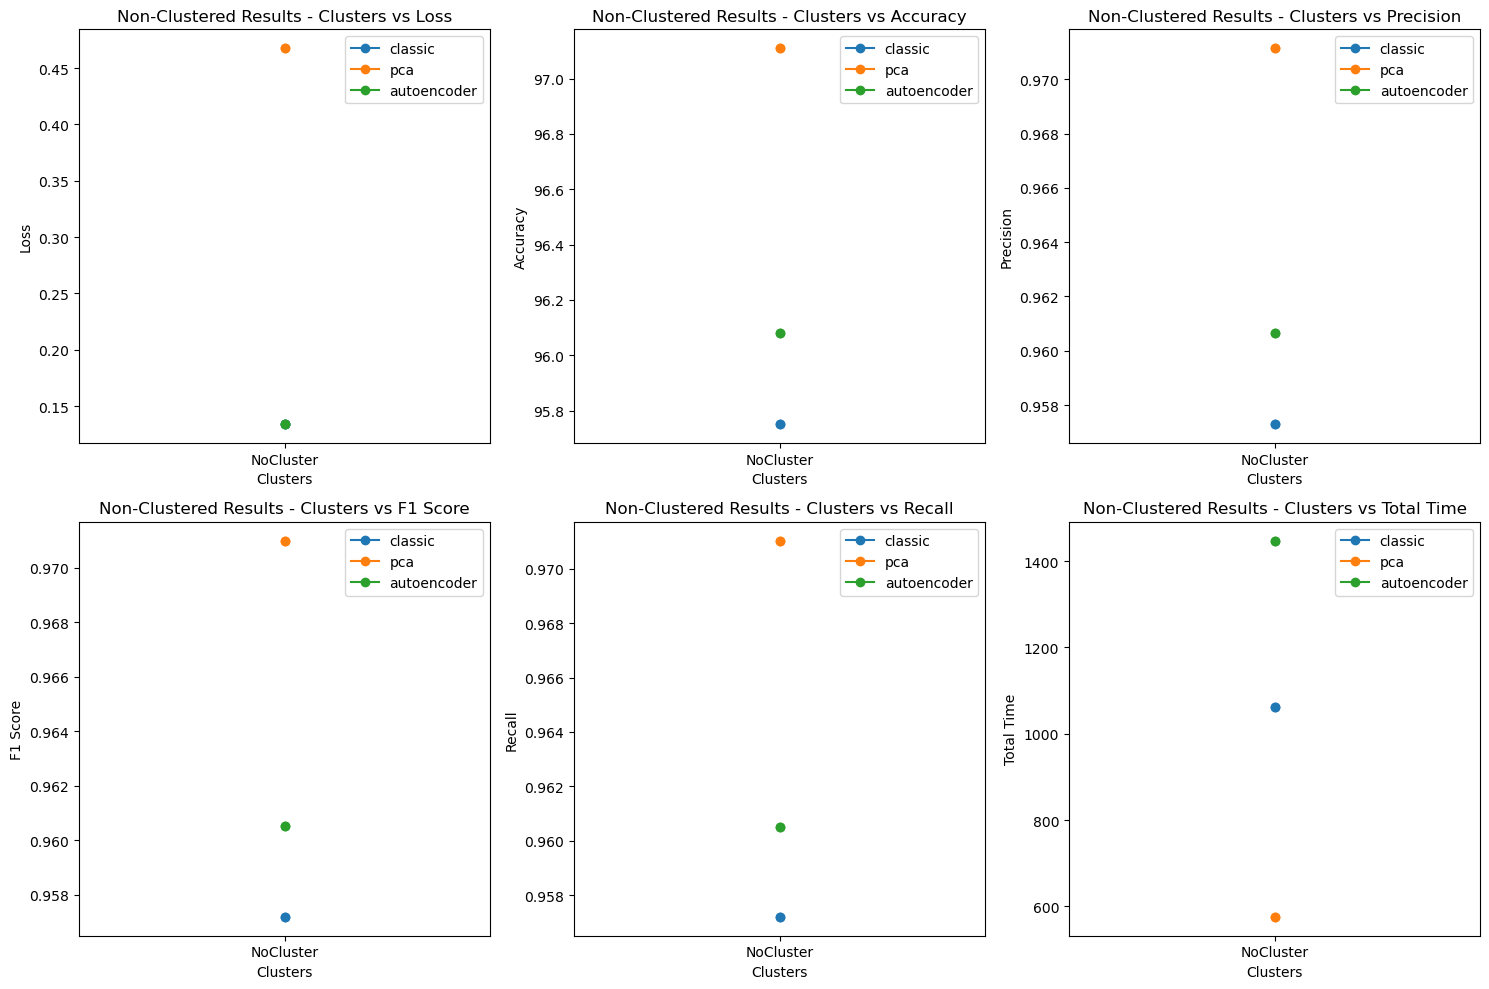


Clustered Results:
classic:
  Final Loss: {2: 0.04812007923126221, 4: 0.03998064956665039, 6: 0.03699978065490723, 8: 0.03528419437408447, 10: 0.034536015129089354}
  Final Accuracy: {2: 98.42, 4: 98.8, 6: 98.87, 8: 98.89, 10: 98.94}
  Final Precision: {2: 0.9842089101610426, 4: 0.9880000010020872, 6: 0.9887333015904402, 8: 0.9888855696260436, 10: 0.9894312580808858}
  Final F1 Score: {2: 0.9841343753151188, 4: 0.9879441458631092, 6: 0.9886442047858187, 8: 0.9888319444366533, 10: 0.9893627971858778}
  Final Recall: {2: 0.9841031264798271, 4: 0.9879145452620067, 6: 0.9885926869808541, 8: 0.9888111509906045, 10: 0.9893276513329836}
  Total Time: {2: 1042.5415015220642, 4: 1147.8886759281158, 6: 1127.9194297790527, 8: 1125.7170586585999, 10: 1152.615125656128}
pca:
  Final Loss: {2: 0.25686016845703125, 4: 0.20505394287109374, 6: 0.19606947479248046, 8: 0.17883182830810546, 10: 0.1794867645263672}
  Final Accuracy: {2: 98.01, 4: 98.16, 6: 98.11, 8: 98.18, 10: 98.17}
  Final Precision: {2

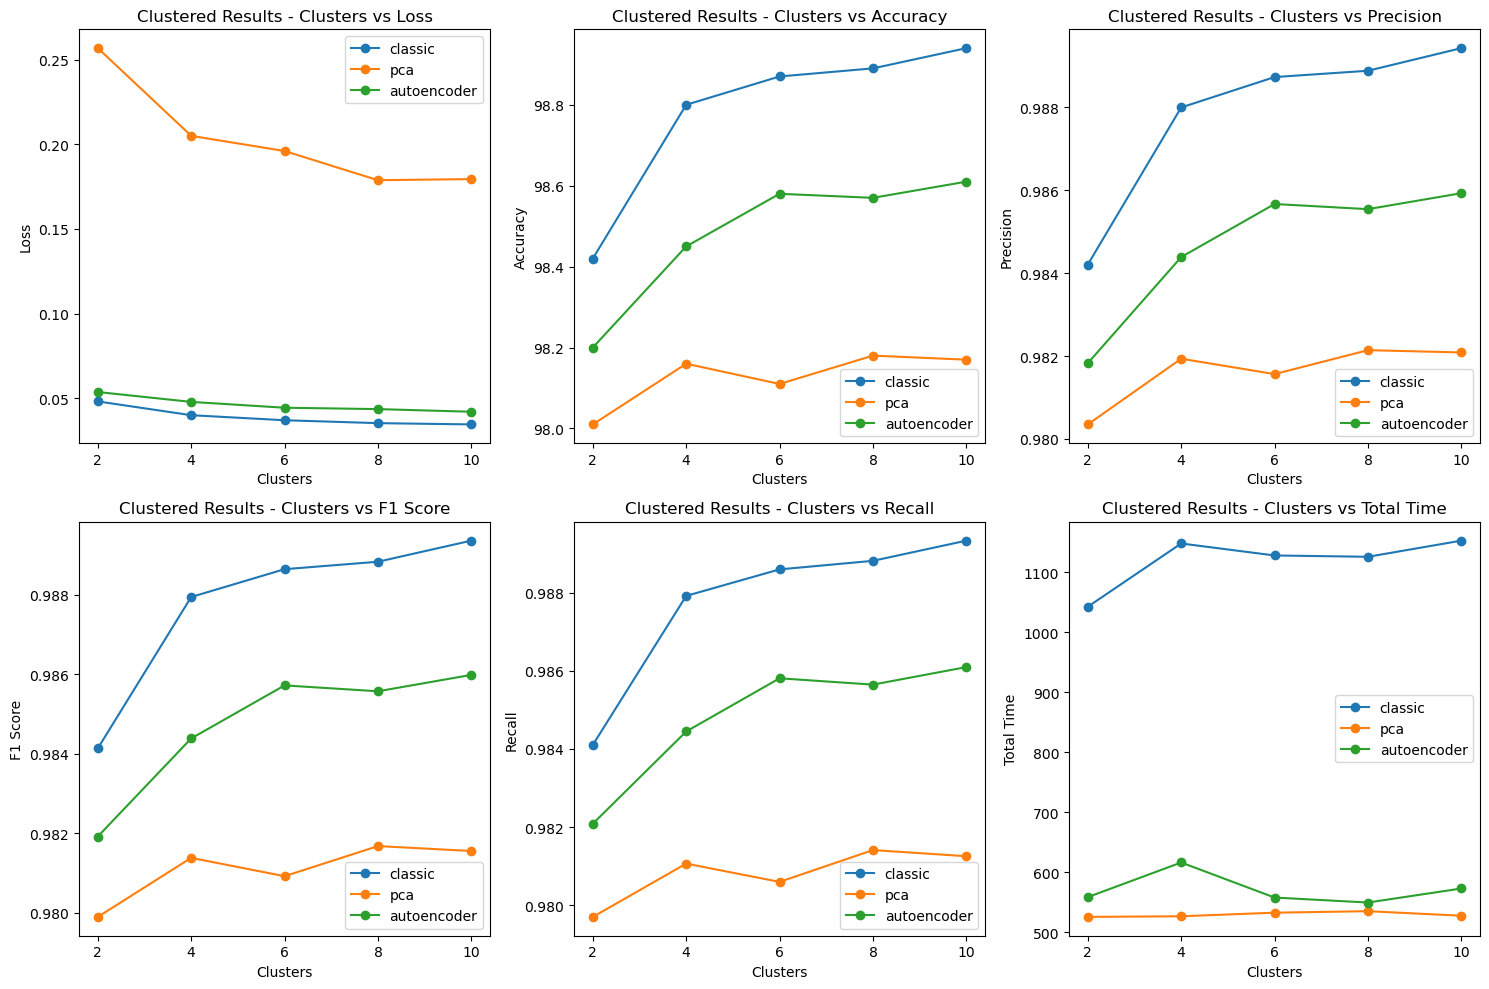

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Function to compute final metrics
def compute_final_metrics(metrics):
    final_loss = {alpha: data['losses'][-1] for alpha, data in metrics.items()}
    final_accuracy = {alpha: data['accuracy'][-1] for alpha, data in metrics.items()}
    final_precision = {alpha: data['precision'][-1] for alpha, data in metrics.items()}
    final_f1 = {alpha: data['f1'][-1] for alpha, data in metrics.items()}
    final_recall = {alpha: data['recall'][-1] for alpha, data in metrics.items()}

    # Sum of all training times
    total_time = {
        alpha: sum(data.get('TrainingTime', data.get('trainingTime', [0])))
        for alpha, data in metrics.items()
    }

    return final_loss, final_accuracy, final_precision, final_f1, final_recall, total_time

# Function to print results
def print_results(results, title):
    print(f"\n{title}:")
    for method in results.keys():
        final_loss, final_accuracy, final_precision, final_f1, final_recall, total_time = compute_final_metrics(results[method])
        print(f"{method}:")
        print("  Final Loss:", final_loss)
        print("  Final Accuracy:", final_accuracy)
        print("  Final Precision:", final_precision)
        print("  Final F1 Score:", final_f1)
        print("  Final Recall:", final_recall)
        print("  Total Time:", total_time)

# Function to plot the results
def plot_results(results, title, filename):
    plt.figure(figsize=(15, 10))

    # List of metrics to plot
    metrics_names = ["Loss", "Accuracy", "Precision", "F1 Score", "Recall", "Total Time"]
    for i, metric in enumerate(metrics_names):
        plt.subplot(2, 3, i + 1)

        # Plotting each method's metrics
        for method in results.keys():
            final_loss, final_accuracy, final_precision, final_f1, final_recall, total_time = compute_final_metrics(results[method])

            # Select the right metric based on the iteration
            metric_values = {
                "Loss": final_loss,
                "Accuracy": final_accuracy,
                "Precision": final_precision,
                "F1 Score": final_f1,
                "Recall": final_recall,
                "Total Time": total_time
            }[metric]

            # Plot the metric values for each method
            plt.plot(list(metric_values.keys()) + ['NoCluster'], list(metric_values.values()) + [metric_values.get('NoCluster', np.nan)], marker='o', label=method)

        plt.xlabel('Clusters')
        plt.ylabel(metric)
        plt.title(f'{title} - Clusters vs {metric}')
        plt.legend()

    # Adjust layout and save the plot
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

# Assuming 'results' and 'clusteredResults' are the data for the methods
# Print and plot results for non-clustered and clustered data

print_results(results, "Non-Clustered Results")
plot_results(results, "Non-Clustered Results", "non_clustered_results.png")

print_results(clusteredResults, "Clustered Results")
plot_results(clusteredResults, "Clustered Results", "clustered_results.png")
